<a href="https://colab.research.google.com/github/Shibata-17086/FieldTransformer/blob/main/fdtd_simulator_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FDTD Simulation Parameters:
  - Grid size: 200 points
  - Spatial step (dx): 1.00e-03 m
  - Time step (dt): 3.17e-12 s
  - Number of time steps: 315571
  - Total simulation time: 1.00e-06 s
  - CFL number: 0.9500
  - Boundary condition: pml
Added Gaussian pulse at position 100 with width 10.0


FDTD Simulation:   0%|          | 0/315571 [00:00<?, ?it/s]

Simulation completed: 315571 time steps (1.00e-06 seconds)
Results saved to fdtd_results.h5


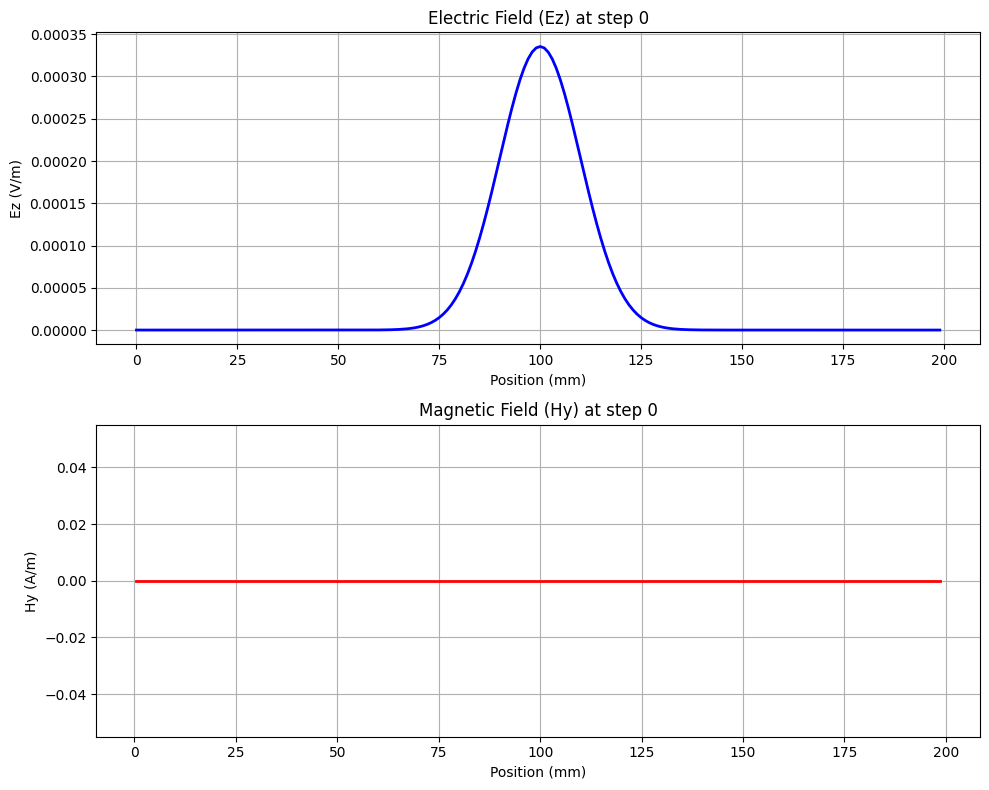

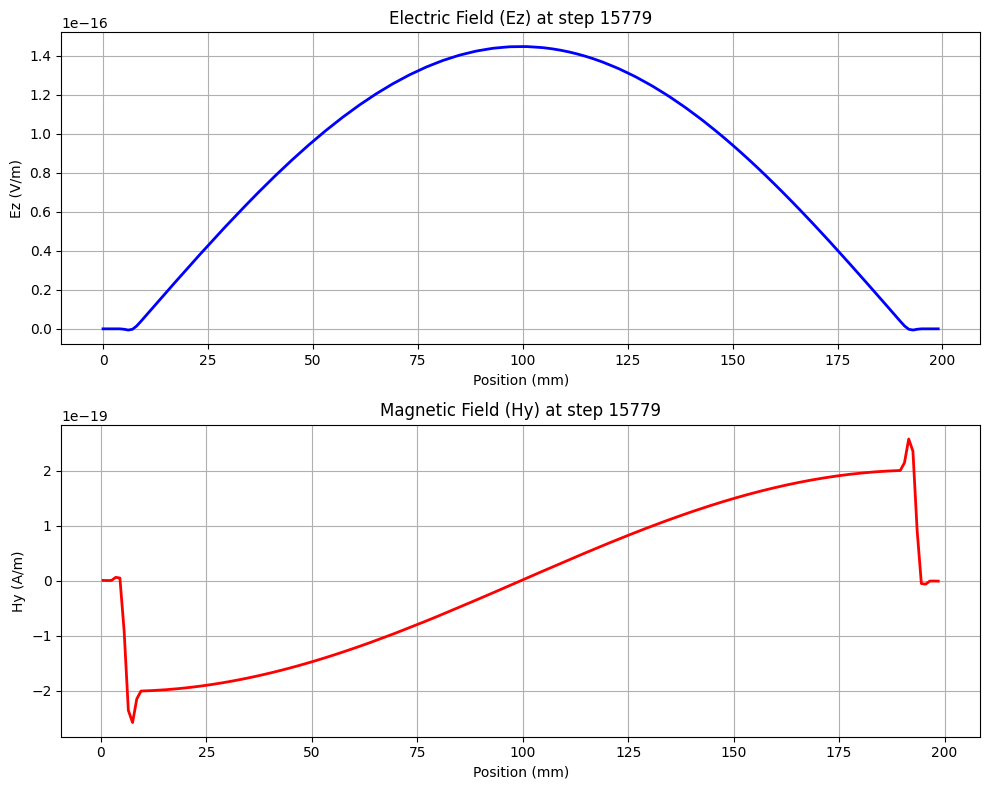

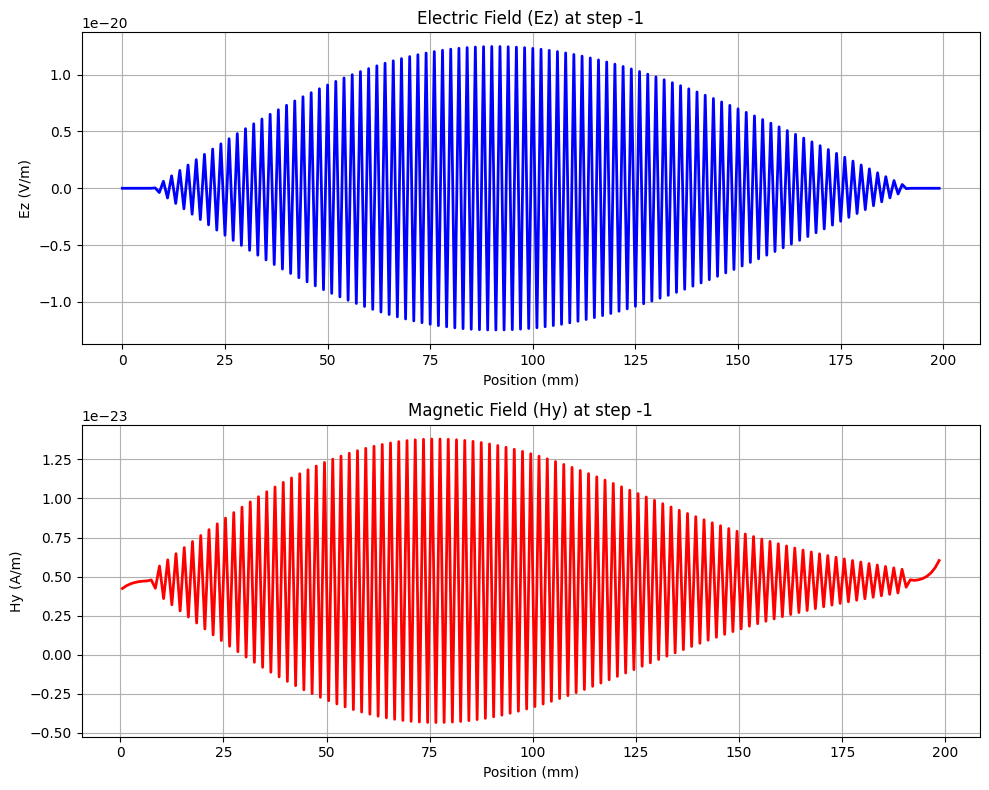

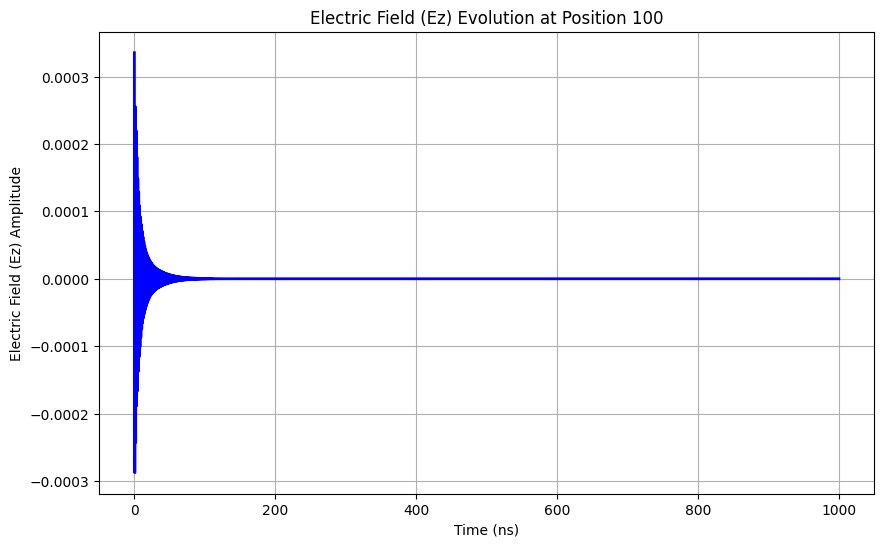

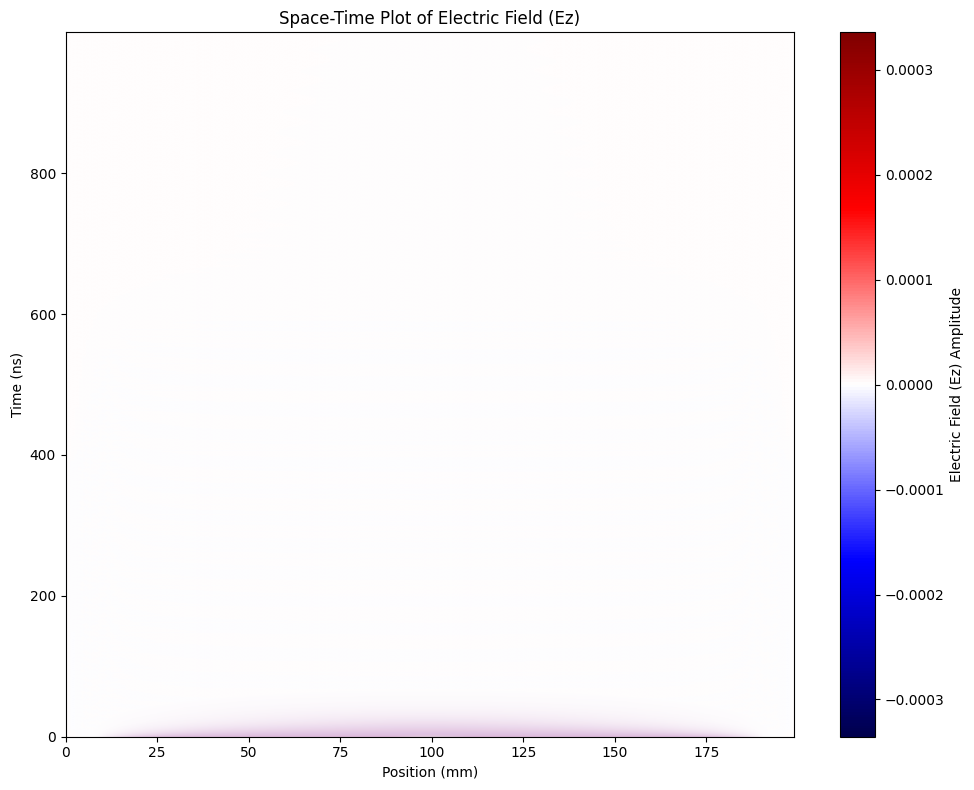

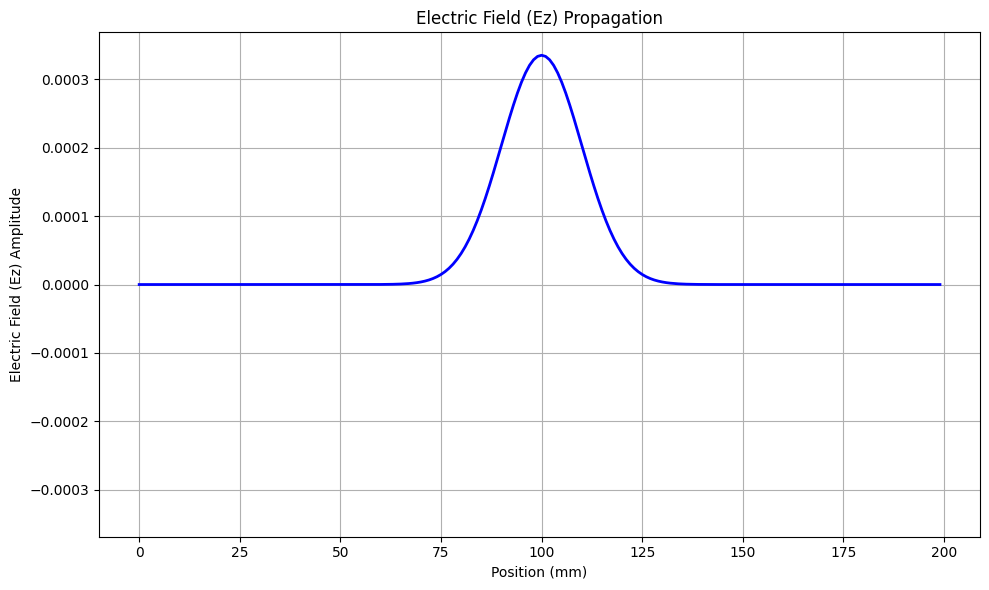

FDTD simulation completed successfully!


In [ ]:
#!/usr/bin/env python3
"""
1D FDTD (Finite-Difference Time-Domain) Electromagnetic Wave Simulator
Notebook-friendly version for Jupyter/Colab environments
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import time
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm  # Using notebook-friendly tqdm

class FDTD1D:
    """
    1D FDTD simulator for electromagnetic wave propagation.
    """

    def __init__(self, nx=200, dx=1e-3, nt=None, dt=None,
                 eps_r=1.0, mu_r=1.0, sigma=0.0,
                 boundary='fixed', pml_layers=10):
        """
        Initialize the 1D FDTD simulator.

        Parameters:
        -----------
        nx : int
            Number of spatial grid points
        dx : float
            Spatial step size (meters)
        nt : int
            Number of time steps (if None, will be calculated from CFL condition)
        dt : float
            Time step size (seconds) (if None, will be calculated from CFL condition)
        eps_r : float or array
            Relative permittivity (can be array for inhomogeneous media)
        mu_r : float or array
            Relative permeability (can be array for inhomogeneous media)
        sigma : float or array
            Conductivity (can be array for inhomogeneous media)
        boundary : str
            Boundary condition type ('fixed', 'pml', 'periodic')
        pml_layers : int
            Number of PML (Perfectly Matched Layer) layers if boundary='pml'
        """
        # Physical constants
        self.c0 = 299792458.0  # Speed of light in vacuum (m/s)
        self.eps0 = 8.85418782e-12  # Vacuum permittivity (F/m)
        self.mu0 = 1.25663706e-6  # Vacuum permeability (H/m)

        # Grid parameters
        self.nx = nx
        self.dx = dx

        # Determine time step based on CFL condition if not provided
        if dt is None:
            # CFL condition: dt <= dx / c
            self.dt = 0.95 * dx / self.c0  # Use 95% of max value for stability
        else:
            self.dt = dt

        # Number of time steps based on requested duration or provided value
        if nt is None:
            # Default to 1 microsecond simulation
            self.nt = int(1e-6 / self.dt)
        else:
            self.nt = nt

        # Domain setup
        if isinstance(eps_r, (int, float)):
            self.eps_r = np.ones(nx) * eps_r
        else:
            self.eps_r = eps_r

        if isinstance(mu_r, (int, float)):
            self.mu_r = np.ones(nx) * mu_r
        else:
            self.mu_r = mu_r

        if isinstance(sigma, (int, float)):
            self.sigma = np.ones(nx) * sigma
        else:
            self.sigma = sigma

        # Derived quantities
        self.eps = self.eps0 * self.eps_r
        self.mu = self.mu0 * self.mu_r

        # Initialize field arrays
        self.ez = np.zeros(nx)
        self.hy = np.zeros(nx-1)

        # Storage for field history (can be memory-intensive for long simulations)
        self.ez_history = None
        self.hy_history = None

        # Update coefficients
        # For Ez update: Ez^{n+1} = ca * Ez^n + cb * (Hy^{n+1/2}_{i} - Hy^{n+1/2}_{i-1})
        # For Hy update: Hy^{n+1/2} = da * Hy^{n-1/2} + db * (Ez^n_{i+1} - Ez^n_{i})
        self.ca = (1.0 - self.sigma * self.dt / (2.0 * self.eps)) / (1.0 + self.sigma * self.dt / (2.0 * self.eps))
        self.cb = self.dt / (self.dx * self.eps * (1.0 + self.sigma * self.dt / (2.0 * self.eps)))
        self.da = np.ones(nx-1)  # For lossless medium
        self.db = self.dt / (self.mu[:-1] * self.dx)

        # Boundary condition setup
        self.boundary = boundary
        self.pml_layers = pml_layers

        if boundary == 'pml':
            self._setup_pml()

        # Print simulation parameters
        print(f"FDTD Simulation Parameters:")
        print(f"  - Grid size: {nx} points")
        print(f"  - Spatial step (dx): {dx:.2e} m")
        print(f"  - Time step (dt): {self.dt:.2e} s")
        print(f"  - Number of time steps: {self.nt}")
        print(f"  - Total simulation time: {self.nt * self.dt:.2e} s")
        print(f"  - CFL number: {self.c0 * self.dt / self.dx:.4f}")
        print(f"  - Boundary condition: {boundary}")

    def _setup_pml(self):
        """
        Set up the PML (Perfectly Matched Layer) absorbing boundary condition.
        """
        # Reflection coefficient (theoretical)
        R_0 = 1e-8

        # PML parameters
        sigma_max = -(3 + 1) * np.log(R_0) / (2 * self.dx * self.pml_layers)

        # Initialize PML arrays
        # Left boundary
        sigma_left = np.zeros(self.nx)
        for i in range(self.pml_layers):
            x = (self.pml_layers - i) / self.pml_layers
            sigma_left[i] = sigma_max * x**3

        # Right boundary
        sigma_right = np.zeros(self.nx)
        for i in range(self.pml_layers):
            x = (i + 1) / self.pml_layers
            sigma_right[self.nx - self.pml_layers + i] = sigma_max * x**3

        # Combine into a single sigma profile
        self.pml_sigma = sigma_left + sigma_right

        # Update the FDTD update coefficients
        self.ca = (1.0 - (self.sigma + self.pml_sigma) * self.dt / (2.0 * self.eps)) / \
                  (1.0 + (self.sigma + self.pml_sigma) * self.dt / (2.0 * self.eps))
        self.cb = self.dt / (self.dx * self.eps * (1.0 + (self.sigma + self.pml_sigma) * self.dt / (2.0 * self.eps)))

        # Similar for magnetic field (if magnetic losses were included)
        # For simplicity, we keep magnetic field lossless

    def add_gaussian_pulse(self, position=None, width=10, amplitude=1.0, delay=40):
        """
        Add a Gaussian pulse to the electric field as an initial condition or source.

        Parameters:
        -----------
        position : int or None
            Center position of the pulse (if None, use the center of the grid)
        width : float
            Width of the Gaussian pulse (standard deviation in grid points)
        amplitude : float
            Amplitude of the pulse
        delay : float
            Time delay of the pulse (in grid points)
        """
        if position is None:
            position = self.nx // 2

        # Gaussian pulse
        x = np.arange(self.nx)
        self.ez = amplitude * np.exp(-(x - position)**2 / (2 * width**2)) * np.exp(-(delay)**2 / (2 * width**2))

        print(f"Added Gaussian pulse at position {position} with width {width}")

    def add_sine_source(self, frequency, position=None, amplitude=1.0):
        """
        Add a sine wave source to the specified position.
        Note: This source will be updated during time stepping.

        Parameters:
        -----------
        frequency : float
            Frequency of the sine wave (Hz)
        position : int or None
            Position to place the source (if None, use the center of the grid)
        amplitude : float
            Amplitude of the source
        """
        if position is None:
            position = self.nx // 2

        self.source_position = position
        self.source_frequency = frequency
        self.source_amplitude = amplitude
        self.has_sine_source = True

        print(f"Added sine source at position {position} with frequency {frequency} Hz")

    def update_fields(self):
        """
        Update the electric and magnetic fields for one time step.
        """
        # Update electric field (Ez)
        for i in range(1, self.nx-1):
            self.ez[i] = self.ca[i] * self.ez[i] + self.cb[i] * (self.hy[i] - self.hy[i-1])

        # Apply boundary conditions for Ez
        if self.boundary == 'fixed':
            # Fixed boundary (Ez = 0 at boundaries)
            self.ez[0] = 0
            self.ez[-1] = 0
        elif self.boundary == 'periodic':
            # Periodic boundary
            self.ez[0] = self.ca[0] * self.ez[0] + self.cb[0] * (self.hy[0] - self.hy[-1])
            self.ez[-1] = self.ca[-1] * self.ez[-1] + self.cb[-1] * (self.hy[0] - self.hy[-2])
        # For PML, we already adjusted the update coefficients

        # Update magnetic field (Hy)
        for i in range(self.nx-1):
            self.hy[i] = self.da[i] * self.hy[i] + self.db[i] * (self.ez[i+1] - self.ez[i])

    def run_simulation(self, save_every=1, save_fields=True, progress_bar=True):
        """
        Run the FDTD simulation for the specified number of time steps.

        Parameters:
        -----------
        save_every : int
            Save field values every 'save_every' time steps
        save_fields : bool
            Whether to save field values for later use
        progress_bar : bool
            Whether to display a progress bar

        Returns:
        --------
        ez_history : ndarray
            Electric field history if save_fields=True
        hy_history : ndarray
            Magnetic field history if save_fields=True
        """
        # Calculate how many snapshots to save
        self.n_snapshots = self.nt // save_every + 1

        # Initialize arrays to store field history
        if save_fields:
            self.ez_history = np.zeros((self.n_snapshots, self.nx))
            self.hy_history = np.zeros((self.n_snapshots, self.nx-1))

            # Save initial state
            self.ez_history[0, :] = self.ez
            self.hy_history[0, :] = self.hy

        # Run simulation with progress bar if requested
        range_iter = tqdm(range(1, self.nt + 1), desc="FDTD Simulation") if progress_bar else range(1, self.nt + 1)

        # Main FDTD time-stepping loop
        for n in range_iter:
            # Update fields
            self.update_fields()

            # Save fields if needed
            if save_fields and n % save_every == 0:
                idx = n // save_every
                self.ez_history[idx, :] = self.ez
                self.hy_history[idx, :] = self.hy

        print(f"Simulation completed: {self.nt} time steps ({self.nt * self.dt:.2e} seconds)")

        if save_fields:
            return self.ez_history, self.hy_history
        else:
            return None, None

    def save_results(self, filename='fdtd_results.h5'):
        """
        Save simulation results to an HDF5 file.

        Parameters:
        -----------
        filename : str
            Name of the HDF5 file to save results
        """
        if self.ez_history is None or self.hy_history is None:
            raise ValueError("No field history to save. Run the simulation with save_fields=True first.")

        with h5py.File(filename, 'w') as f:
            # Create datasets for electric and magnetic fields
            f.create_dataset('ez_field', data=self.ez_history)
            f.create_dataset('hy_field', data=self.hy_history)

            # Add metadata attributes
            f.attrs['nx'] = self.nx
            f.attrs['dx'] = self.dx
            f.attrs['nt'] = self.nt
            f.attrs['dt'] = self.dt
            f.attrs['save_every'] = self.nt // (self.n_snapshots - 1)
            f.attrs['boundary'] = self.boundary
            f.attrs['timestamp'] = time.time()

        print(f"Results saved to {filename}")

    def plot_fields(self, step=None, show=True, save=False, filename='fields.png'):
        """
        Plot the electric and magnetic fields at a specific time step.

        Parameters:
        -----------
        step : int or None
            Time step to plot (if None, plot the current fields)
        show : bool
            Whether to display the plot
        save : bool
            Whether to save the plot to a file
        filename : str
            Filename to save the plot
        """
        if step is not None and (self.ez_history is None or self.hy_history is None):
            raise ValueError("No field history to plot. Run the simulation with save_fields=True first.")

        x = np.arange(self.nx) * self.dx * 1000  # Convert to mm for readability
        x_hy = (np.arange(self.nx-1) + 0.5) * self.dx * 1000  # Hy is offset by half a cell

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

        # Electric field
        if step is None:
            ax1.plot(x, self.ez, 'b-', linewidth=2)
        else:
            ax1.plot(x, self.ez_history[step, :], 'b-', linewidth=2)

        ax1.set_title(f'Electric Field (Ez) at step {step if step is not None else "current"}')
        ax1.set_xlabel('Position (mm)')
        ax1.set_ylabel('Ez (V/m)')
        ax1.grid(True)

        # Magnetic field
        if step is None:
            ax2.plot(x_hy, self.hy, 'r-', linewidth=2)
        else:
            ax2.plot(x_hy, self.hy_history[step, :], 'r-', linewidth=2)

        ax2.set_title(f'Magnetic Field (Hy) at step {step if step is not None else "current"}')
        ax2.set_xlabel('Position (mm)')
        ax2.set_ylabel('Hy (A/m)')
        ax2.grid(True)

        plt.tight_layout()

        if save:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {filename}")

        if show:
            plt.show()
        else:
            plt.close()

    def plot_field_evolution(self, field='ez', position=None, show=True, save=False, filename='evolution.png'):
        """
        Plot the time evolution of a field at a specific position.

        Parameters:
        -----------
        field : str
            Field to plot ('ez' or 'hy')
        position : int
            Spatial position to monitor (if None, use the middle of the grid)
        show : bool
            Whether to display the plot
        save : bool
            Whether to save the plot to a file
        filename : str
            Filename to save the plot
        """
        if self.ez_history is None or self.hy_history is None:
            raise ValueError("No field history to plot. Run the simulation with save_fields=True first.")

        if position is None:
            position = self.nx // 2

        time_points = np.arange(self.n_snapshots) * (self.nt // (self.n_snapshots - 1)) * self.dt * 1e9  # Convert to ns

        plt.figure(figsize=(10, 6))

        if field.lower() == 'ez':
            plt.plot(time_points, self.ez_history[:, position], 'b-', linewidth=2)
            field_label = 'Electric Field (Ez)'
        elif field.lower() == 'hy':
            hy_position = min(position, self.nx-2)
            plt.plot(time_points, self.hy_history[:, hy_position], 'r-', linewidth=2)
            field_label = 'Magnetic Field (Hy)'
        else:
            raise ValueError("Field must be 'ez' or 'hy'")

        plt.title(f'{field_label} Evolution at Position {position}')
        plt.xlabel('Time (ns)')
        plt.ylabel(f'{field_label} Amplitude')
        plt.grid(True)

        if save:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {filename}")

        if show:
            plt.show()
        else:
            plt.close()

    def create_animation(self, field='ez', interval=50, save=False, filename='fdtd_animation.mp4'):
        """
        Create and display an animation of the field propagation.

        Parameters:
        -----------
        field : str
            Field to animate ('ez' or 'hy')
        interval : int
            Interval between frames in milliseconds
        save : bool
            Whether to save the animation
        filename : str
            Filename to save the animation
        """
        if self.ez_history is None or self.hy_history is None:
            raise ValueError("No field history to animate. Run the simulation with save_fields=True first.")

        fig, ax = plt.subplots(figsize=(10, 6))

        x = np.arange(self.nx) * self.dx * 1000  # Convert to mm

        if field.lower() == 'ez':
            plot_data = self.ez_history
            field_label = 'Electric Field (Ez)'
        elif field.lower() == 'hy':
            plot_data = self.hy_history
            x = (np.arange(self.nx-1) + 0.5) * self.dx * 1000  # Hy is offset by half a cell
            field_label = 'Magnetic Field (Hy)'
        else:
            raise ValueError("Field must be 'ez' or 'hy'")

        # Find max amplitude for consistent y-axis scaling
        max_val = np.max(np.abs(plot_data))

        line, = ax.plot(x, plot_data[0], 'b-' if field.lower() == 'ez' else 'r-', linewidth=2)

        # Add a time indicator
        time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

        ax.set_ylim(-max_val*1.1, max_val*1.1)
        ax.set_xlabel('Position (mm)')
        ax.set_ylabel(f'{field_label} Amplitude')
        ax.set_title(f'{field_label} Propagation')
        ax.grid(True)

        def init():
            line.set_ydata(plot_data[0])
            time_text.set_text('')
            return line, time_text

        def animate(i):
            line.set_ydata(plot_data[i])
            time_text.set_text(f'Time: {i * (self.nt // (self.n_snapshots - 1)) * self.dt * 1e9:.2f} ns')
            return line, time_text

        ani = FuncAnimation(fig, animate, frames=self.n_snapshots,
                            init_func=init, blit=True, interval=interval)

        if save:
            ani.save(filename, writer='ffmpeg', fps=30)
            print(f"Animation saved to {filename}")

        plt.tight_layout()
        plt.show()

    def plot_spacetime(self, field='ez', show=True, save=False, filename='spacetime.png'):
        """
        Create a space-time plot (x-t plot) showing the field evolution.

        Parameters:
        -----------
        field : str
            Field to plot ('ez' or 'hy')
        show : bool
            Whether to display the plot
        save : bool
            Whether to save the plot to a file
        filename : str
            Filename to save the plot
        """
        if self.ez_history is None or self.hy_history is None:
            raise ValueError("No field history to plot. Run the simulation with save_fields=True first.")

        fig, ax = plt.subplots(figsize=(10, 8))

        if field.lower() == 'ez':
            field_data = self.ez_history
            field_label = 'Electric Field (Ez)'
            x = np.arange(self.nx) * self.dx * 1000  # Convert to mm
        elif field.lower() == 'hy':
            field_data = self.hy_history
            field_label = 'Magnetic Field (Hy)'
            x = (np.arange(self.nx-1) + 0.5) * self.dx * 1000  # Hy is offset by half a cell
        else:
            raise ValueError("Field must be 'ez' or 'hy'")

        t = np.arange(self.n_snapshots) * (self.nt // (self.n_snapshots - 1)) * self.dt * 1e9  # Convert to ns

        # Create the space-time image
        im = ax.imshow(field_data, aspect='auto', origin='lower',
                       extent=[x.min(), x.max(), t.min(), t.max()],
                       cmap='seismic', vmin=-np.max(np.abs(field_data)), vmax=np.max(np.abs(field_data)))

        ax.set_title(f'Space-Time Plot of {field_label}')
        ax.set_xlabel('Position (mm)')
        ax.set_ylabel('Time (ns)')

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(f'{field_label} Amplitude')

        plt.tight_layout()

        if save:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {filename}")

        if show:
            plt.show()
        else:
            plt.close()

def run_fdtd_simulation(nx=200, dx=1e-3, sim_time=1e-6, dt_factor=0.95,
                       eps_r=1.0, mu_r=1.0, sigma=0.0,
                       pulse_width=10.0, pulse_delay=40.0, pulse_amplitude=1.0,
                       boundary='fixed', pml_layers=10,
                       save_every=10, output_file='fdtd_results.h5',
                       visualize=True, save_plots=False):
    """
    Run FDTD simulation with the given parameters.
    This function is designed to be called directly from notebooks.

    Parameters:
    -----------
    nx : int
        Number of spatial grid points
    dx : float
        Spatial step size (meters)
    sim_time : float
        Simulation time (seconds)
    dt_factor : float
        Factor for CFL condition (0-1)
    eps_r : float
        Relative permittivity
    mu_r : float
        Relative permeability
    sigma : float
        Conductivity (S/m)
    pulse_width : float
        Width of Gaussian pulse (grid points)
    pulse_delay : float
        Delay of Gaussian pulse (grid points)
    pulse_amplitude : float
        Amplitude of Gaussian pulse
    boundary : str
        Boundary condition type ('fixed', 'pml', 'periodic')
    pml_layers : int
        Number of PML layers if boundary='pml'
    save_every : int
        Save field values every n time steps
    output_file : str
        Output HDF5 file name
    visualize : bool
        Visualize the results
    save_plots : bool
        Save the plots

    Returns:
    --------
    fdtd : FDTD1D
        The FDTD simulator object with results
    """
    # Calculate dt based on CFL condition and requested factor
    dt = dt_factor * dx / 299792458.0

    # Calculate total number of time steps
    nt = int(sim_time / dt)

    # Create FDTD simulator
    fdtd = FDTD1D(nx=nx, dx=dx, nt=nt, dt=dt,
                 eps_r=eps_r, mu_r=mu_r, sigma=sigma,
                 boundary=boundary, pml_layers=pml_layers)

    # Add Gaussian pulse source
    fdtd.add_gaussian_pulse(position=None,  # Center of grid
                           width=pulse_width,
                           amplitude=pulse_amplitude,
                           delay=pulse_delay)

    # Run simulation
    fdtd.run_simulation(save_every=save_every)

    # Save results
    fdtd.save_results(filename=output_file)

    # Visualize if requested
    if visualize or save_plots:
        # Plot initial, middle, and final state
        fdtd.plot_fields(step=0, show=visualize,
                        save=save_plots, filename='fields_initial.png')
        fdtd.plot_fields(step=fdtd.n_snapshots // 2, show=visualize,
                        save=save_plots, filename='fields_middle.png')
        fdtd.plot_fields(step=-1, show=visualize,
                        save=save_plots, filename='fields_final.png')

        # Plot center point evolution
        fdtd.plot_field_evolution(field='ez', position=None, show=visualize,
                                 save=save_plots, filename='evolution_center.png')

        # Plot spacetime diagram
        fdtd.plot_spacetime(field='ez', show=visualize,
                           save=save_plots, filename='spacetime.png')

        # Create animation
        if visualize:
            fdtd.create_animation(field='ez', save=save_plots, filename='fdtd_animation.mp4')

    print("FDTD simulation completed successfully!")
    return fdtd


# Example notebook usage
if __name__ == "__main__":
    # This code will NOT be executed when imported as a module
    fdtd = run_fdtd_simulation(
        nx=200,
        sim_time=1e-6,
        boundary='pml',
        visualize=True
    )

FDTD Simulation Parameters:
  - Grid size: 200 points
  - Spatial step (dx): 1.00e-03 m
  - Time step (dt): 3.17e-12 s
  - Number of time steps: 315571
  - Total simulation time: 1.00e-06 s
  - CFL number: 0.9500
  - Boundary condition: pml
Added Gaussian pulse at position 100 with width 10.0


FDTD Simulation:   0%|          | 0/315571 [00:00<?, ?it/s]

Simulation completed: 315571 time steps (1.00e-06 seconds)
Results saved to fdtd_results.h5


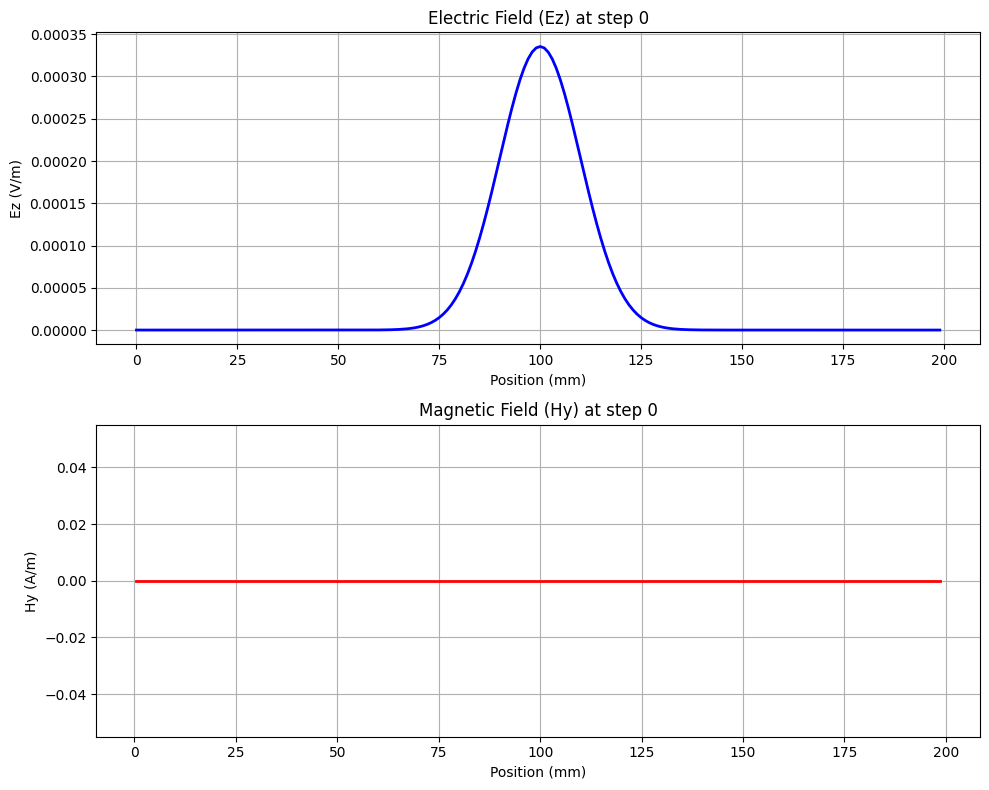

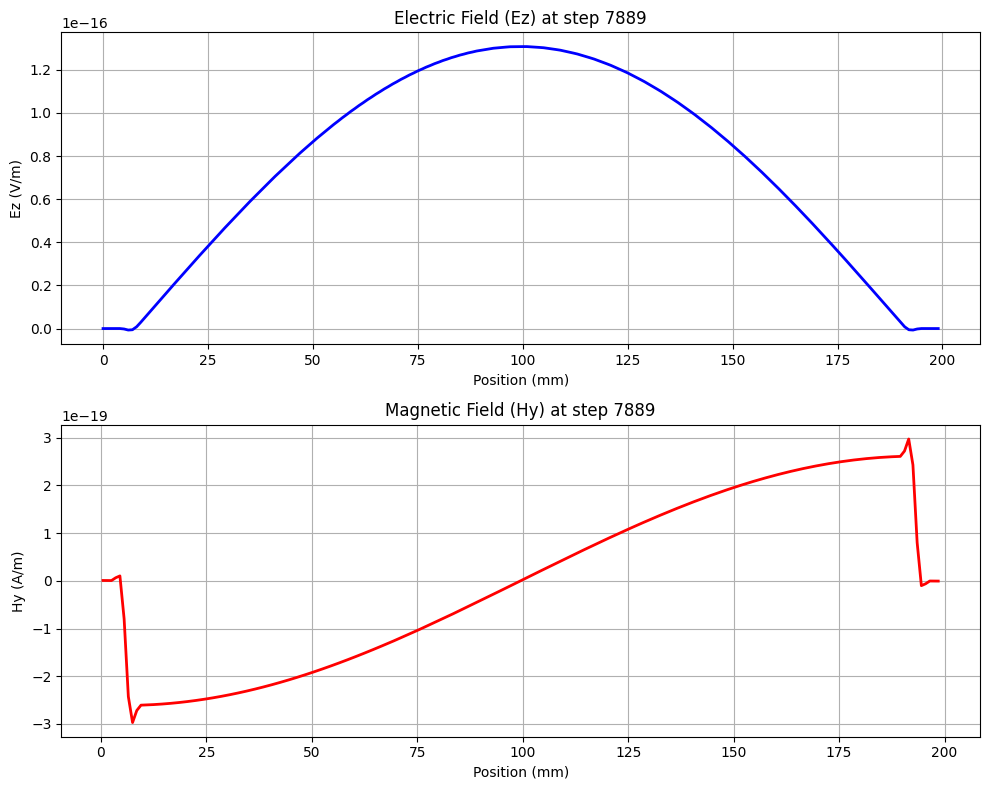

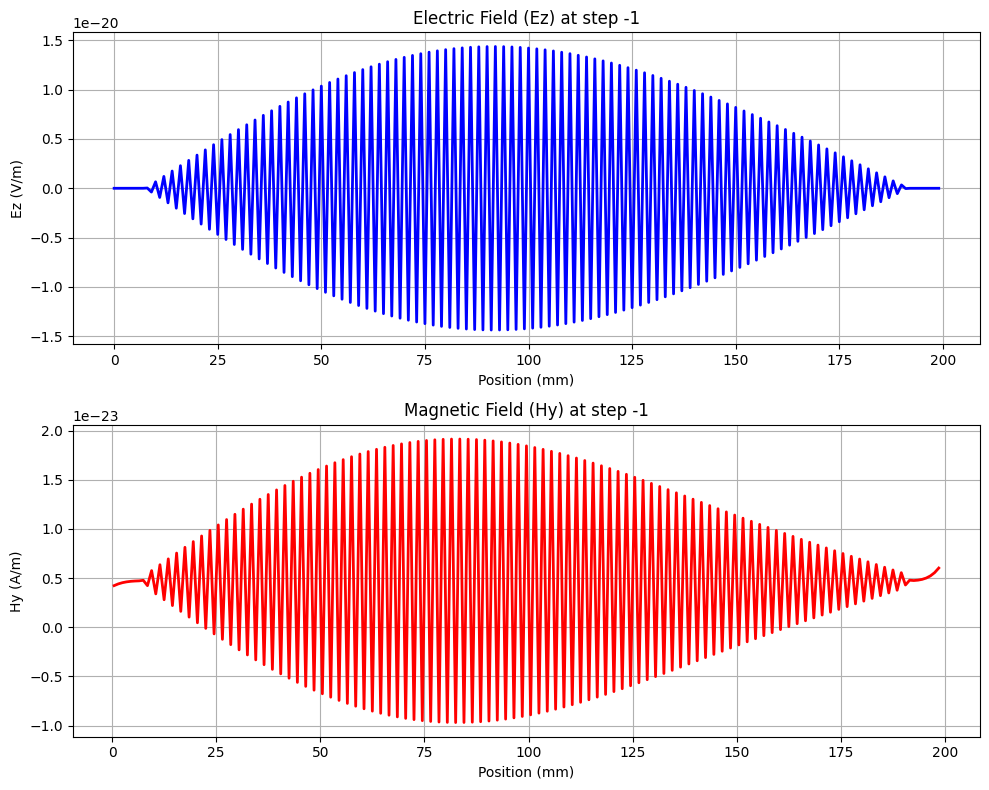

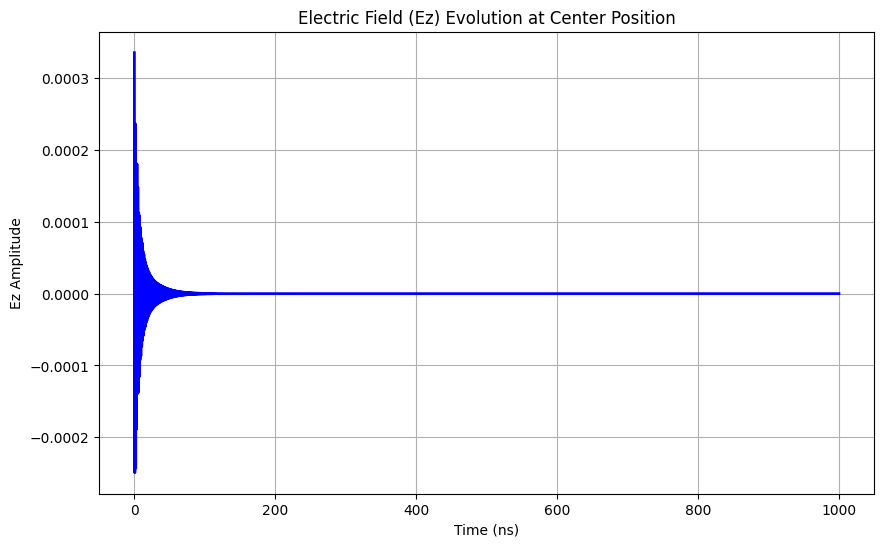

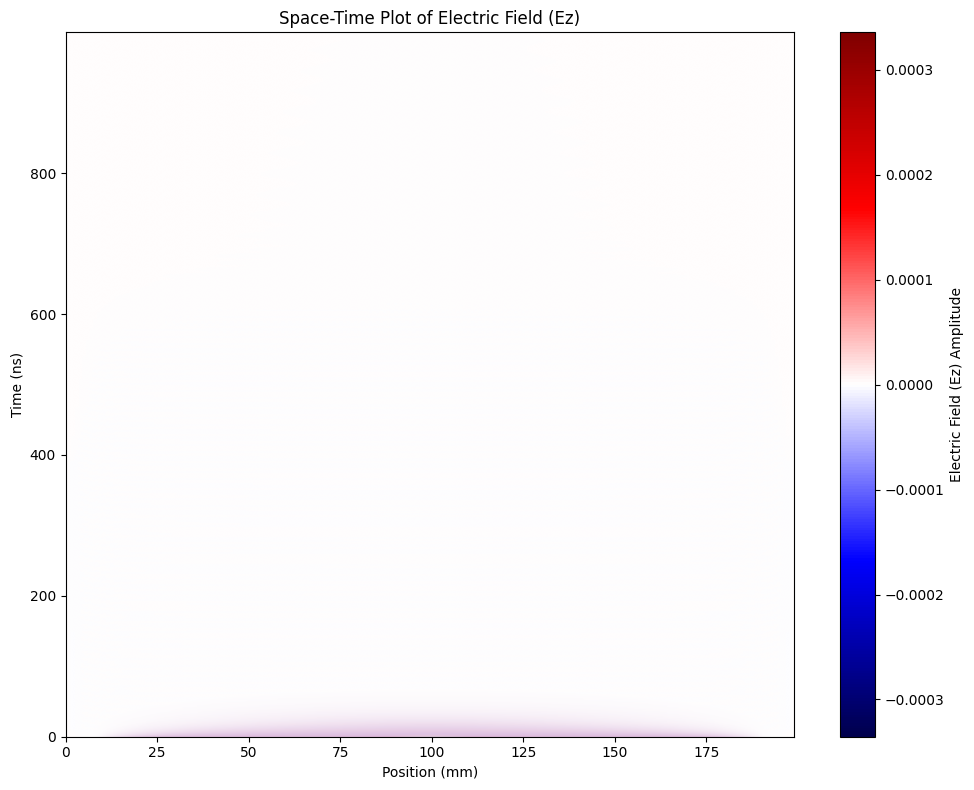

FDTD simulation completed successfully!


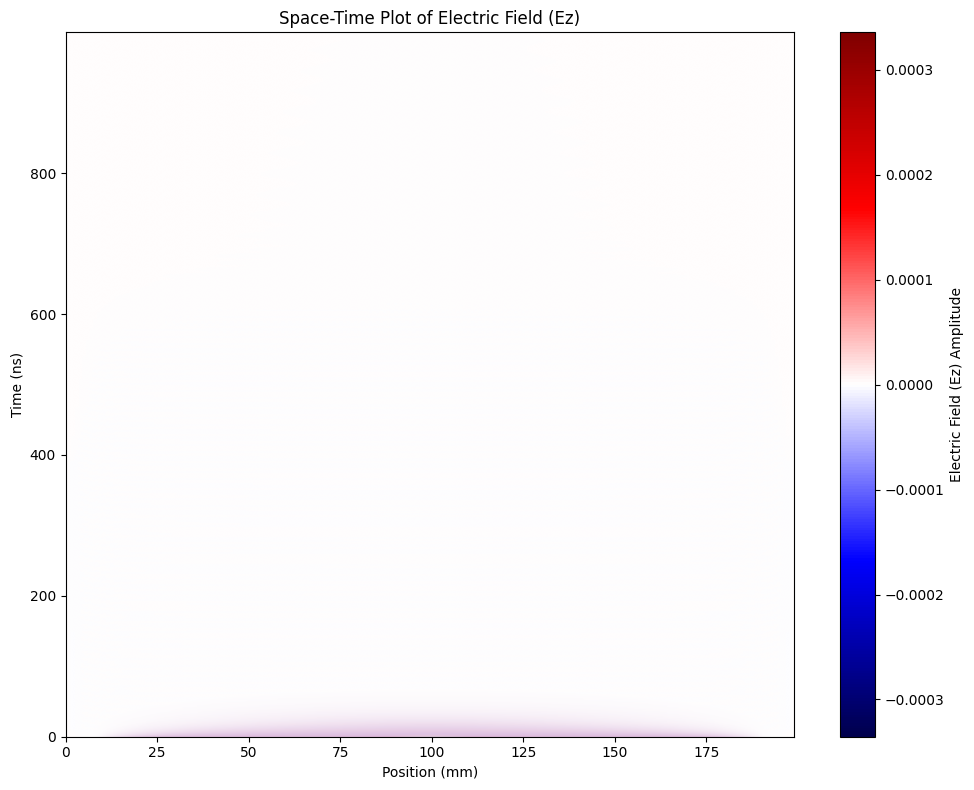

Loading FDTD data from fdtd_results.h5...
Electric field data shape: (15779, 200)
Magnetic field data shape: (15779, 199)
Normalizing data...
Electric field normalized by max value: 0.00033546262790251185
Magnetic field normalized by max value: 7.995396514324232e-07
Creating time windows with 20 input steps and 1 output steps...
Electric and magnetic fields have different spatial dimensions: 200 vs 199
Interpolating magnetic field to match electric field grid...
Interpolated magnetic field shape: (15779, 200)
Stacking electric and magnetic fields...
Created 7880 samples
Splitting into train, validation, and test sets...
Train set: 5516 samples
Validation set: 1182 samples
Test set: 1182 samples
Saving processed data to transformer_dataset.h5...
Dataset creation complete!


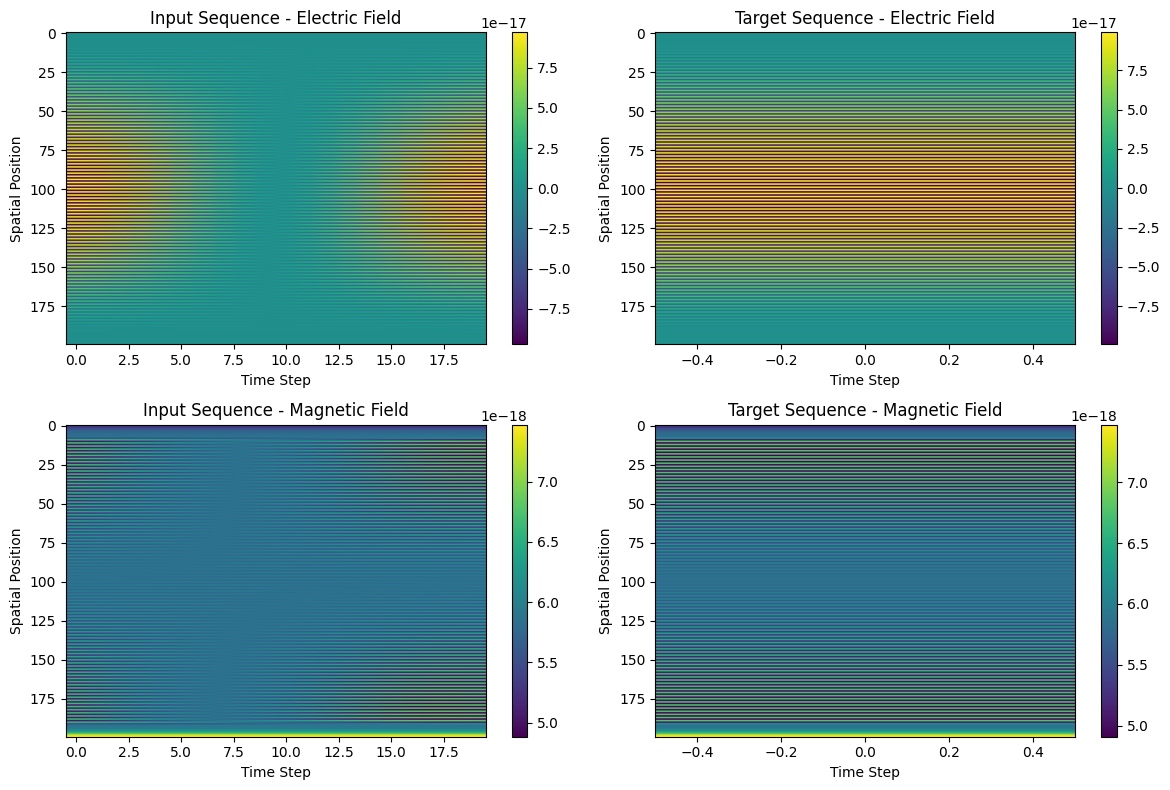

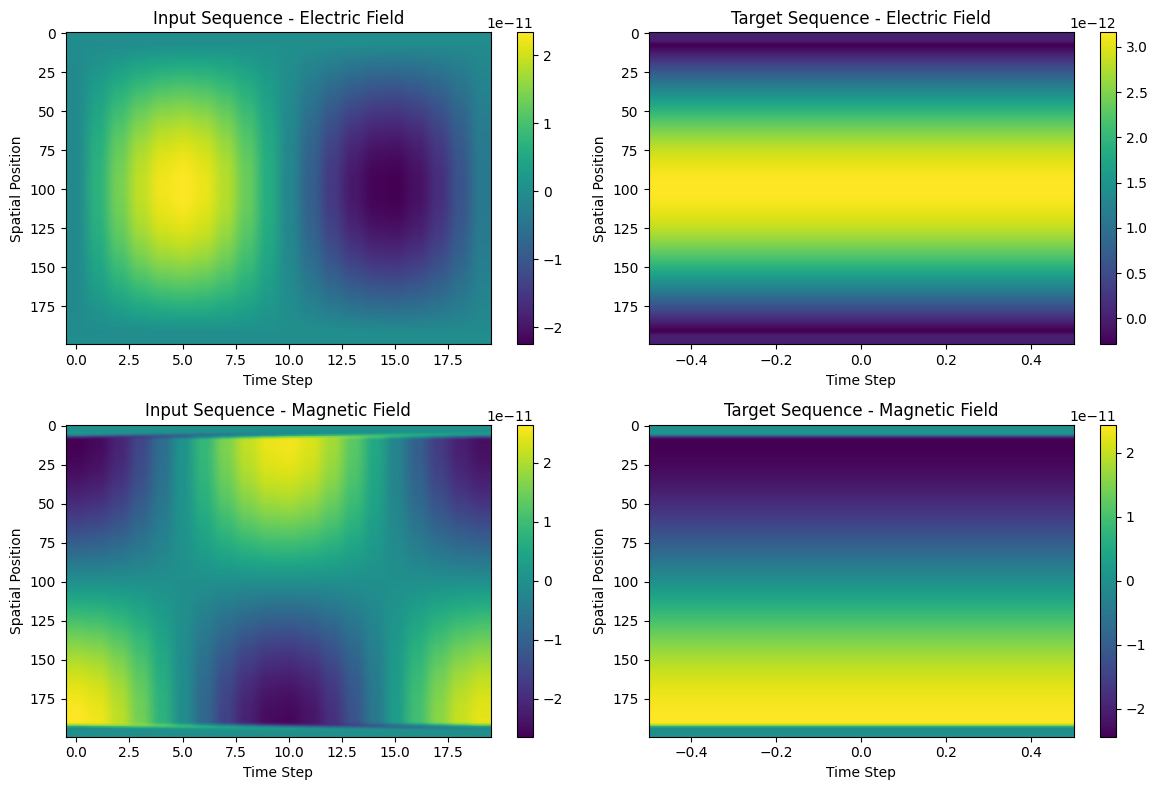

In [ ]:
# FDTD電磁界シミュレーションとTransformerモデル学習データ生成
#
# Colabやノートブックで直接実行可能な形式で、ここに完全なコードをまとめています。

# ## 1. 必要なライブラリのインポート

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import time
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm  # ノートブック用のプログレスバー
from sklearn.model_selection import train_test_split

# ## 2. FDTD (Finite-Difference Time-Domain) シミュレータのクラス

class FDTD1D:
    """
    1D FDTD simulator for electromagnetic wave propagation.
    """

    def __init__(self, nx=200, dx=1e-3, nt=None, dt=None,
                 eps_r=1.0, mu_r=1.0, sigma=0.0,
                 boundary='fixed', pml_layers=10):
        """
        Initialize the 1D FDTD simulator.

        Parameters:
        -----------
        nx : int
            Number of spatial grid points
        dx : float
            Spatial step size (meters)
        nt : int
            Number of time steps (if None, will be calculated from CFL condition)
        dt : float
            Time step size (seconds) (if None, will be calculated from CFL condition)
        eps_r : float or array
            Relative permittivity (can be array for inhomogeneous media)
        mu_r : float or array
            Relative permeability (can be array for inhomogeneous media)
        sigma : float or array
            Conductivity (can be array for inhomogeneous media)
        boundary : str
            Boundary condition type ('fixed', 'pml', 'periodic')
        pml_layers : int
            Number of PML (Perfectly Matched Layer) layers if boundary='pml'
        """
        # Physical constants
        self.c0 = 299792458.0  # Speed of light in vacuum (m/s)
        self.eps0 = 8.85418782e-12  # Vacuum permittivity (F/m)
        self.mu0 = 1.25663706e-6  # Vacuum permeability (H/m)

        # Grid parameters
        self.nx = nx
        self.dx = dx

        # Determine time step based on CFL condition if not provided
        if dt is None:
            # CFL condition: dt <= dx / c
            self.dt = 0.95 * dx / self.c0  # Use 95% of max value for stability
        else:
            self.dt = dt

        # Number of time steps based on requested duration or provided value
        if nt is None:
            # Default to 1 microsecond simulation
            self.nt = int(1e-6 / self.dt)
        else:
            self.nt = nt

        # Domain setup
        if isinstance(eps_r, (int, float)):
            self.eps_r = np.ones(nx) * eps_r
        else:
            self.eps_r = eps_r

        if isinstance(mu_r, (int, float)):
            self.mu_r = np.ones(nx) * mu_r
        else:
            self.mu_r = mu_r

        if isinstance(sigma, (int, float)):
            self.sigma = np.ones(nx) * sigma
        else:
            self.sigma = sigma

        # Derived quantities
        self.eps = self.eps0 * self.eps_r
        self.mu = self.mu0 * self.mu_r

        # Initialize field arrays
        self.ez = np.zeros(nx)
        self.hy = np.zeros(nx-1)

        # Storage for field history (can be memory-intensive for long simulations)
        self.ez_history = None
        self.hy_history = None

        # Update coefficients
        # For Ez update: Ez^{n+1} = ca * Ez^n + cb * (Hy^{n+1/2}_{i} - Hy^{n+1/2}_{i-1})
        # For Hy update: Hy^{n+1/2} = da * Hy^{n-1/2} + db * (Ez^n_{i+1} - Ez^n_{i})
        self.ca = (1.0 - self.sigma * self.dt / (2.0 * self.eps)) / (1.0 + self.sigma * self.dt / (2.0 * self.eps))
        self.cb = self.dt / (self.dx * self.eps * (1.0 + self.sigma * self.dt / (2.0 * self.eps)))
        self.da = np.ones(nx-1)  # For lossless medium
        self.db = self.dt / (self.mu[:-1] * self.dx)

        # Boundary condition setup
        self.boundary = boundary
        self.pml_layers = pml_layers

        if boundary == 'pml':
            self._setup_pml()

        # Print simulation parameters
        print(f"FDTD Simulation Parameters:")
        print(f"  - Grid size: {nx} points")
        print(f"  - Spatial step (dx): {dx:.2e} m")
        print(f"  - Time step (dt): {self.dt:.2e} s")
        print(f"  - Number of time steps: {self.nt}")
        print(f"  - Total simulation time: {self.nt * self.dt:.2e} s")
        print(f"  - CFL number: {self.c0 * self.dt / self.dx:.4f}")
        print(f"  - Boundary condition: {boundary}")

    def _setup_pml(self):
        """
        Set up the PML (Perfectly Matched Layer) absorbing boundary condition.
        """
        # Reflection coefficient (theoretical)
        R_0 = 1e-8

        # PML parameters
        sigma_max = -(3 + 1) * np.log(R_0) / (2 * self.dx * self.pml_layers)

        # Initialize PML arrays
        # Left boundary
        sigma_left = np.zeros(self.nx)
        for i in range(self.pml_layers):
            x = (self.pml_layers - i) / self.pml_layers
            sigma_left[i] = sigma_max * x**3

        # Right boundary
        sigma_right = np.zeros(self.nx)
        for i in range(self.pml_layers):
            x = (i + 1) / self.pml_layers
            sigma_right[self.nx - self.pml_layers + i] = sigma_max * x**3

        # Combine into a single sigma profile
        self.pml_sigma = sigma_left + sigma_right

        # Update the FDTD update coefficients
        self.ca = (1.0 - (self.sigma + self.pml_sigma) * self.dt / (2.0 * self.eps)) / \
                  (1.0 + (self.sigma + self.pml_sigma) * self.dt / (2.0 * self.eps))
        self.cb = self.dt / (self.dx * self.eps * (1.0 + (self.sigma + self.pml_sigma) * self.dt / (2.0 * self.eps)))

        # Similar for magnetic field (if magnetic losses were included)
        # For simplicity, we keep magnetic field lossless

    def add_gaussian_pulse(self, position=None, width=10, amplitude=1.0, delay=40):
        """
        Add a Gaussian pulse to the electric field as an initial condition or source.

        Parameters:
        -----------
        position : int or None
            Center position of the pulse (if None, use the center of the grid)
        width : float
            Width of the Gaussian pulse (standard deviation in grid points)
        amplitude : float
            Amplitude of the pulse
        delay : float
            Time delay of the pulse (in grid points)
        """
        if position is None:
            position = self.nx // 2

        # Gaussian pulse
        x = np.arange(self.nx)
        self.ez = amplitude * np.exp(-(x - position)**2 / (2 * width**2)) * np.exp(-(delay)**2 / (2 * width**2))

        print(f"Added Gaussian pulse at position {position} with width {width}")

    def update_fields(self):
        """
        Update the electric and magnetic fields for one time step.
        """
        # Update electric field (Ez)
        for i in range(1, self.nx-1):
            self.ez[i] = self.ca[i] * self.ez[i] + self.cb[i] * (self.hy[i] - self.hy[i-1])

        # Apply boundary conditions for Ez
        if self.boundary == 'fixed':
            # Fixed boundary (Ez = 0 at boundaries)
            self.ez[0] = 0
            self.ez[-1] = 0
        elif self.boundary == 'periodic':
            # Periodic boundary
            self.ez[0] = self.ca[0] * self.ez[0] + self.cb[0] * (self.hy[0] - self.hy[-1])
            self.ez[-1] = self.ca[-1] * self.ez[-1] + self.cb[-1] * (self.hy[0] - self.hy[-2])
        # For PML, we already adjusted the update coefficients

        # Update magnetic field (Hy)
        for i in range(self.nx-1):
            self.hy[i] = self.da[i] * self.hy[i] + self.db[i] * (self.ez[i+1] - self.ez[i])

    def run_simulation(self, save_every=1, save_fields=True, progress_bar=True):
        """
        Run the FDTD simulation for the specified number of time steps.

        Parameters:
        -----------
        save_every : int
            Save field values every 'save_every' time steps
        save_fields : bool
            Whether to save field values for later use
        progress_bar : bool
            Whether to display a progress bar

        Returns:
        --------
        ez_history : ndarray
            Electric field history if save_fields=True
        hy_history : ndarray
            Magnetic field history if save_fields=True
        """
        # Calculate how many snapshots to save
        self.n_snapshots = self.nt // save_every + 1

        # Initialize arrays to store field history
        if save_fields:
            self.ez_history = np.zeros((self.n_snapshots, self.nx))
            self.hy_history = np.zeros((self.n_snapshots, self.nx-1))

            # Save initial state
            self.ez_history[0, :] = self.ez
            self.hy_history[0, :] = self.hy

        # Run simulation with progress bar if requested
        range_iter = tqdm(range(1, self.nt + 1), desc="FDTD Simulation") if progress_bar else range(1, self.nt + 1)

        # Main FDTD time-stepping loop
        for n in range_iter:
            # Update fields
            self.update_fields()

            # Save fields if needed
            if save_fields and n % save_every == 0:
                idx = n // save_every
                self.ez_history[idx, :] = self.ez
                self.hy_history[idx, :] = self.hy

        print(f"Simulation completed: {self.nt} time steps ({self.nt * self.dt:.2e} seconds)")

        if save_fields:
            return self.ez_history, self.hy_history
        else:
            return None, None

    def save_results(self, filename='fdtd_results.h5'):
        """
        Save simulation results to an HDF5 file.

        Parameters:
        -----------
        filename : str
            Name of the HDF5 file to save results
        """
        if self.ez_history is None or self.hy_history is None:
            raise ValueError("No field history to save. Run the simulation with save_fields=True first.")

        with h5py.File(filename, 'w') as f:
            # Create datasets for electric and magnetic fields
            f.create_dataset('ez_field', data=self.ez_history)
            f.create_dataset('hy_field', data=self.hy_history)

            # Add metadata attributes
            f.attrs['nx'] = self.nx
            f.attrs['dx'] = self.dx
            f.attrs['nt'] = self.nt
            f.attrs['dt'] = self.dt
            f.attrs['save_every'] = self.nt // (self.n_snapshots - 1)
            f.attrs['boundary'] = self.boundary
            f.attrs['timestamp'] = time.time()

        print(f"Results saved to {filename}")

    def plot_fields(self, step=None, show=True, save=False, filename='fields.png'):
        """
        Plot the electric and magnetic fields at a specific time step.

        Parameters:
        -----------
        step : int or None
            Time step to plot (if None, plot the current fields)
        show : bool
            Whether to display the plot
        save : bool
            Whether to save the plot to a file
        filename : str
            Filename to save the plot
        """
        if step is not None and (self.ez_history is None or self.hy_history is None):
            raise ValueError("No field history to plot. Run the simulation with save_fields=True first.")

        x = np.arange(self.nx) * self.dx * 1000  # Convert to mm for readability
        x_hy = (np.arange(self.nx-1) + 0.5) * self.dx * 1000  # Hy is offset by half a cell

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

        # Electric field
        if step is None:
            ax1.plot(x, self.ez, 'b-', linewidth=2)
        else:
            ax1.plot(x, self.ez_history[step, :], 'b-', linewidth=2)

        ax1.set_title(f'Electric Field (Ez) at step {step if step is not None else "current"}')
        ax1.set_xlabel('Position (mm)')
        ax1.set_ylabel('Ez (V/m)')
        ax1.grid(True)

        # Magnetic field
        if step is None:
            ax2.plot(x_hy, self.hy, 'r-', linewidth=2)
        else:
            ax2.plot(x_hy, self.hy_history[step, :], 'r-', linewidth=2)

        ax2.set_title(f'Magnetic Field (Hy) at step {step if step is not None else "current"}')
        ax2.set_xlabel('Position (mm)')
        ax2.set_ylabel('Hy (A/m)')
        ax2.grid(True)

        plt.tight_layout()

        if save:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {filename}")

        if show:
            plt.show()
        else:
            plt.close()

    def plot_spacetime(self, field='ez', show=True, save=False, filename='spacetime.png'):
        """
        Create a space-time plot (x-t plot) showing the field evolution.

        Parameters:
        -----------
        field : str
            Field to plot ('ez' or 'hy')
        show : bool
            Whether to display the plot
        save : bool
            Whether to save the plot to a file
        filename : str
            Filename to save the plot
        """
        if self.ez_history is None or self.hy_history is None:
            raise ValueError("No field history to plot. Run the simulation with save_fields=True first.")

        fig, ax = plt.subplots(figsize=(10, 8))

        if field.lower() == 'ez':
            field_data = self.ez_history
            field_label = 'Electric Field (Ez)'
            x = np.arange(self.nx) * self.dx * 1000  # Convert to mm
        elif field.lower() == 'hy':
            field_data = self.hy_history
            field_label = 'Magnetic Field (Hy)'
            x = (np.arange(self.nx-1) + 0.5) * self.dx * 1000  # Hy is offset by half a cell
        else:
            raise ValueError("Field must be 'ez' or 'hy'")

        t = np.arange(self.n_snapshots) * (self.nt // (self.n_snapshots - 1)) * self.dt * 1e9  # Convert to ns

        # Create the space-time image
        im = ax.imshow(field_data, aspect='auto', origin='lower',
                       extent=[x.min(), x.max(), t.min(), t.max()],
                       cmap='seismic', vmin=-np.max(np.abs(field_data)), vmax=np.max(np.abs(field_data)))

        ax.set_title(f'Space-Time Plot of {field_label}')
        ax.set_xlabel('Position (mm)')
        ax.set_ylabel('Time (ns)')

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(f'{field_label} Amplitude')

        plt.tight_layout()

        if save:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {filename}")

        if show:
            plt.show()
        else:
            plt.close()

# ## 3. FDTDシミュレーション実行関数

# run_fdtd_simulation関数の修正

def run_fdtd_simulation(nx=200, dx=1e-3, sim_time=1e-6, dt_factor=0.95,
                       eps_r=1.0, mu_r=1.0, sigma=0.0,
                       pulse_width=10.0, pulse_delay=40.0, pulse_amplitude=1.0,
                       boundary='fixed', pml_layers=10,
                       save_every=10, output_file='fdtd_results.h5',
                       visualize=True, save_plots=False):
    """
    Run FDTD simulation with the given parameters.
    This function is designed to be called directly from notebooks.

    Parameters:
    -----------
    nx : int
        Number of spatial grid points
    dx : float
        Spatial step size (meters)
    sim_time : float
        Simulation time (seconds)
    dt_factor : float
        Factor for CFL condition (0-1)
    eps_r : float
        Relative permittivity
    mu_r : float
        Relative permeability
    sigma : float
        Conductivity (S/m)
    pulse_width : float
        Width of Gaussian pulse (grid points)
    pulse_delay : float
        Delay of Gaussian pulse (grid points)
    pulse_amplitude : float
        Amplitude of Gaussian pulse
    boundary : str
        Boundary condition type ('fixed', 'pml', 'periodic')
    pml_layers : int
        Number of PML layers if boundary='pml'
    save_every : int
        Save field values every n time steps
    output_file : str
        Output HDF5 file name
    visualize : bool
        Visualize the results
    save_plots : bool
        Save the plots

    Returns:
    --------
    fdtd : FDTD1D
        The FDTD simulator object with results
    """
    # Calculate dt based on CFL condition and requested factor
    dt = dt_factor * dx / 299792458.0

    # Calculate total number of time steps
    nt = int(sim_time / dt)

    # Create FDTD simulator
    fdtd = FDTD1D(nx=nx, dx=dx, nt=nt, dt=dt,
                 eps_r=eps_r, mu_r=mu_r, sigma=sigma,
                 boundary=boundary, pml_layers=pml_layers)

    # Add Gaussian pulse source
    fdtd.add_gaussian_pulse(position=None,  # Center of grid
                           width=pulse_width,
                           amplitude=pulse_amplitude,
                           delay=pulse_delay)

    # Run simulation
    fdtd.run_simulation(save_every=save_every)

    # Save results
    fdtd.save_results(filename=output_file)

    # Visualize if requested
    if visualize or save_plots:
        # Plot initial, middle, and final state
        fdtd.plot_fields(step=0, show=visualize,
                        save=save_plots, filename='fields_initial.png')
        fdtd.plot_fields(step=fdtd.n_snapshots // 2, show=visualize,
                        save=save_plots, filename='fields_middle.png')
        fdtd.plot_fields(step=-1, show=visualize,
                        save=save_plots, filename='fields_final.png')

        # これをコメントアウトします
        # fdtd.plot_field_evolution(field='ez', position=None, show=visualize,
        #                           save=save_plots, filename='evolution_center.png')

        # 代わりに中央ポイントの電場を直接プロットすることもできます
        if hasattr(fdtd, 'ez_history') and fdtd.ez_history is not None:
            center_point = fdtd.nx // 2
            time_points = np.arange(fdtd.n_snapshots) * (fdtd.nt // (fdtd.n_snapshots - 1)) * fdtd.dt * 1e9

            plt.figure(figsize=(10, 6))
            plt.plot(time_points, fdtd.ez_history[:, center_point], 'b-', linewidth=2)
            plt.title(f'Electric Field (Ez) Evolution at Center Position')
            plt.xlabel('Time (ns)')
            plt.ylabel('Ez Amplitude')
            plt.grid(True)

            if save_plots:
                plt.savefig('evolution_center.png', dpi=300, bbox_inches='tight')

            if visualize:
                plt.show()
            else:
                plt.close()

        # Plot spacetime diagram
        fdtd.plot_spacetime(field='ez', show=visualize,
                           save=save_plots, filename='spacetime.png')

    print("FDTD simulation completed successfully!")
    return fdtd




# ## 4. Transformerモデル用データセット作成関数
# create_fdtd_dataset関数の修正

def create_fdtd_dataset(fdtd_data_path, input_time_steps=20, output_time_steps=1,
                        include_magnetic_field=False, stride=2, test_split=0.15,
                        val_split=0.15, normalize=True, save_path='fdtd_dataset.h5',
                        interpolate_magnetic=True):
    """
    Create training dataset from FDTD simulation results for Transformer model.

    Parameters:
    -----------
    fdtd_data_path : str
        Path to the FDTD simulation results file
    input_time_steps : int
        Number of past time steps to use as input
    output_time_steps : int
        Number of future time steps to predict
    include_magnetic_field : bool
        Whether to include magnetic field components (if available)
    stride : int
        Step size for sliding window
    test_split : float
        Proportion of data to use for testing
    val_split : float
        Proportion of data to use for validation
    normalize : bool
        Whether to normalize the data
    save_path : str
        Path to save the processed dataset
    interpolate_magnetic : bool
        Whether to interpolate magnetic field to match electric field grid

    Returns:
    --------
    dict
        Dictionary containing train, val, and test datasets
    """
    # Load FDTD data
    print(f"Loading FDTD data from {fdtd_data_path}...")

    # Determine file type and load appropriately
    if fdtd_data_path.endswith('.npy'):
        # Assume it's just Ez field
        ez_field = np.load(fdtd_data_path)
        include_magnetic_field = False  # Override since we only have Ez
    elif fdtd_data_path.endswith('.h5'):
        with h5py.File(fdtd_data_path, 'r') as f:
            # Check what fields are available
            if 'ez_field' in f:
                ez_field = f['ez_field'][:]
            elif 'Ez' in f:
                ez_field = f['Ez'][:]
            else:
                # Look for any dataset that might be the E-field
                for key in f.keys():
                    if isinstance(f[key], h5py.Dataset) and len(f[key].shape) == 2:
                        print(f"Using {key} as Ez field")
                        ez_field = f[key][:]
                        break
                else:
                    raise ValueError("Could not find electric field data in the file")

            # Try to load magnetic field if requested
            if include_magnetic_field:
                if 'hy_field' in f:
                    hy_field = f['hy_field'][:]
                elif 'Hy' in f:
                    hy_field = f['Hy'][:]
                else:
                    print("Magnetic field data not found. Proceeding with electric field only.")
                    include_magnetic_field = False
    else:
        # Try to load as numpy array directly
        try:
            ez_field = np.load(fdtd_data_path)
            include_magnetic_field = False
        except:
            raise ValueError(f"Unsupported file format: {fdtd_data_path}")

    print(f"Electric field data shape: {ez_field.shape}")
    if include_magnetic_field:
        print(f"Magnetic field data shape: {hy_field.shape}")

    # Normalize data if requested
    if normalize:
        print("Normalizing data...")
        ez_max = np.max(np.abs(ez_field))
        ez_field = ez_field / ez_max
        print(f"Electric field normalized by max value: {ez_max}")

        if include_magnetic_field:
            hy_max = np.max(np.abs(hy_field))
            hy_field = hy_field / hy_max
            print(f"Magnetic field normalized by max value: {hy_max}")

    # Create time windows for sequence prediction
    print(f"Creating time windows with {input_time_steps} input steps and {output_time_steps} output steps...")

    if include_magnetic_field:
        # Check if Ez and Hy have different spatial dimensions (common in staggered grids)
        if ez_field.shape[1] != hy_field.shape[1]:
            print(f"Electric and magnetic fields have different spatial dimensions: {ez_field.shape[1]} vs {hy_field.shape[1]}")

            if interpolate_magnetic:
                print("Interpolating magnetic field to match electric field grid...")

                # Create interpolated magnetic field with same dimensions as electric field
                hy_field_interp = np.zeros((hy_field.shape[0], ez_field.shape[1]))

                # If magnetic field has one fewer point (typical staggered grid)
                if hy_field.shape[1] == ez_field.shape[1] - 1:
                    # Simple linear interpolation: shift half-cell and pad
                    hy_field_interp[:, 1:-1] = 0.5 * (hy_field[:, :-1] + hy_field[:, 1:])
                    hy_field_interp[:, 0] = hy_field[:, 0]  # Extrapolate first point
                    hy_field_interp[:, -1] = hy_field[:, -1]  # Extrapolate last point

                # If magnetic field has one more point (unusual)
                elif hy_field.shape[1] == ez_field.shape[1] + 1:
                    # Average adjacent values
                    hy_field_interp = 0.5 * (hy_field[:, :-1] + hy_field[:, 1:])

                # Other cases (would require more sophisticated interpolation)
                else:
                    # Use scipy for interpolation
                    from scipy.interpolate import interp1d

                    for t in range(hy_field.shape[0]):
                        # Create interpolation function
                        x_orig = np.linspace(0, 1, hy_field.shape[1])
                        x_new = np.linspace(0, 1, ez_field.shape[1])
                        f = interp1d(x_orig, hy_field[t, :], kind='linear', bounds_error=False, fill_value='extrapolate')

                        # Interpolate
                        hy_field_interp[t, :] = f(x_new)

                print(f"Interpolated magnetic field shape: {hy_field_interp.shape}")
                hy_field = hy_field_interp
            else:
                # Alternative: Truncate electric field to match magnetic field
                print("Truncating electric field to match magnetic field dimensions...")
                if ez_field.shape[1] > hy_field.shape[1]:
                    # Use center portion of electric field
                    diff = ez_field.shape[1] - hy_field.shape[1]
                    start = diff // 2
                    end = ez_field.shape[1] - (diff - start)
                    ez_field = ez_field[:, start:end]
                    print(f"Truncated electric field shape: {ez_field.shape}")

        # Stack fields to create multi-channel data [time, space, channels(Ez, Hy)]
        print("Stacking electric and magnetic fields...")
        combined_field = np.stack([ez_field, hy_field], axis=-1)
        X, y = create_multichannel_windows(combined_field, input_time_steps, output_time_steps, stride)
    else:
        X, y = create_time_windows(ez_field, input_time_steps, output_time_steps, stride)

    print(f"Created {X.shape[0]} samples")

    # Split data into train, validation, and test sets
    print("Splitting into train, validation, and test sets...")
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_split, shuffle=True, random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_split/(1-test_split),
        shuffle=True, random_state=42
    )

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Save the processed data
    if save_path:
        print(f"Saving processed data to {save_path}...")
        with h5py.File(save_path, 'w') as f:
            # Save the datasets
            f.create_dataset('X_train', data=X_train)
            f.create_dataset('y_train', data=y_train)
            f.create_dataset('X_val', data=X_val)
            f.create_dataset('y_val', data=y_val)
            f.create_dataset('X_test', data=X_test)
            f.create_dataset('y_test', data=y_test)

            # Save metadata
            f.attrs['input_time_steps'] = input_time_steps
            f.attrs['output_time_steps'] = output_time_steps
            f.attrs['stride'] = stride
            f.attrs['normalize'] = normalize
            f.attrs['include_magnetic_field'] = include_magnetic_field
            if normalize:
                f.attrs['ez_max'] = ez_max
                if include_magnetic_field:
                    f.attrs['hy_max'] = hy_max

    # Create dataset dictionary for return
    datasets = {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'metadata': {
            'input_time_steps': input_time_steps,
            'output_time_steps': output_time_steps,
            'normalize': normalize,
            'include_magnetic_field': include_magnetic_field
        }
    }

    print("Dataset creation complete!")
    return datasets

def create_time_windows(data, input_time_steps, output_time_steps, stride=1):
    """
    Create sliding windows of input-output pairs from time series data.

    Parameters:
    -----------
    data : ndarray
        Time series data of shape (time_steps, spatial_points)
    input_time_steps : int
        Number of past time steps to use as input
    output_time_steps : int
        Number of future time steps to predict
    stride : int
        Step size for sliding window

    Returns:
    --------
    X : ndarray
        Input sequences of shape (n_samples, input_time_steps, spatial_points)
    y : ndarray
        Target sequences of shape (n_samples, output_time_steps, spatial_points)
    """
    n_time_steps, n_spatial_points = data.shape
    n_samples = (n_time_steps - input_time_steps - output_time_steps) // stride + 1

    X = np.zeros((n_samples, input_time_steps, n_spatial_points))
    y = np.zeros((n_samples, output_time_steps, n_spatial_points))

    for i in range(n_samples):
        start_idx = i * stride
        end_idx = start_idx + input_time_steps
        X[i] = data[start_idx:end_idx]
        y[i] = data[end_idx:end_idx+output_time_steps]

    return X, y

def create_multichannel_windows(data, input_time_steps, output_time_steps, stride=1):
    """
    Create sliding windows of input-output pairs from multichannel time series data.

    Parameters:
    -----------
    data : ndarray
        Time series data of shape (time_steps, spatial_points, channels)
    input_time_steps : int
        Number of past time steps to use as input
    output_time_steps : int
        Number of future time steps to predict
    stride : int
        Step size for sliding window

    Returns:
    --------
    X : ndarray
        Input sequences of shape (n_samples, input_time_steps, spatial_points, channels)
    y : ndarray
        Target sequences of shape (n_samples, output_time_steps, spatial_points, channels)
    """
    n_time_steps, n_spatial_points, n_channels = data.shape
    n_samples = (n_time_steps - input_time_steps - output_time_steps) // stride + 1

    X = np.zeros((n_samples, input_time_steps, n_spatial_points, n_channels))
    y = np.zeros((n_samples, output_time_steps, n_spatial_points, n_channels))

    for i in range(n_samples):
        start_idx = i * stride
        end_idx = start_idx + input_time_steps
        X[i] = data[start_idx:end_idx]
        y[i] = data[end_idx:end_idx+output_time_steps]

    return X, y

def visualize_samples(datasets, num_samples=3):
    """
    Visualize random samples from the dataset.

    Parameters:
    -----------
    datasets : dict
        Dictionary containing X_train, y_train, etc.
    num_samples : int
        Number of samples to visualize
    """
    X_train = datasets['X_train']
    y_train = datasets['y_train']

    for i in range(num_samples):
        sample_idx = np.random.randint(0, X_train.shape[0])

        input_seq = X_train[sample_idx]
        target_seq = y_train[sample_idx]

        # Handle both single-channel and multi-channel data
        if len(input_seq.shape) == 3:  # (time, space, channels)
            n_channels = input_seq.shape[2]
            fig, axs = plt.subplots(n_channels, 2, figsize=(12, 4*n_channels))

            for c in range(n_channels):
                if n_channels > 1:
                    ax1, ax2 = axs[c]
                    channel_name = "Electric Field" if c == 0 else "Magnetic Field"
                else:
                    ax1, ax2 = axs
                    channel_name = "Electric Field"

                im1 = ax1.imshow(input_seq[:, :, c].T, aspect='auto', cmap='viridis')
                ax1.set_title(f'Input Sequence - {channel_name}')
                ax1.set_xlabel('Time Step')
                ax1.set_ylabel('Spatial Position')
                plt.colorbar(im1, ax=ax1)

                im2 = ax2.imshow(target_seq[:, :, c].T, aspect='auto', cmap='viridis')
                ax2.set_title(f'Target Sequence - {channel_name}')
                ax2.set_xlabel('Time Step')
                ax2.set_ylabel('Spatial Position')
                plt.colorbar(im2, ax=ax2)
        else:  # (time, space)
            fig, axs = plt.subplots(1, 2, figsize=(15, 5))

            im1 = axs[0].imshow(input_seq.T, aspect='auto', cmap='viridis')
            axs[0].set_title('Input Sequence - Electric Field')
            axs[0].set_xlabel('Time Step')
            axs[0].set_ylabel('Spatial Position')
            plt.colorbar(im1, ax=axs[0])

            im2 = axs[1].imshow(target_seq.T, aspect='auto', cmap='viridis')
            axs[1].set_title('Target Sequence - Electric Field')
            axs[1].set_xlabel('Time Step')
            axs[1].set_ylabel('Spatial Position')
            plt.colorbar(im2, ax=axs[1])

        plt.tight_layout()
        plt.show()

# ## 5. 実行例



# 1. FDTDシミュレーション実行
fdtd = run_fdtd_simulation(
    nx=200,                # 空間グリッド点数
    dx=1e-3,               # 空間ステップ (m)
    sim_time=1e-6,         # シミュレーション時間 (1μs)
    boundary='pml',        # 吸収境界条件を使用
    pulse_width=10.0,      # ガウスパルスの幅
    pulse_amplitude=1.0,   # パルス振幅
    save_every=20,         # 20ステップごとにデータを保存
    output_file='fdtd_results.h5'  # 出力ファイル名
)

# 2. 時空間プロットの表示
fdtd.plot_spacetime(field='ez')

# 3. Transformerモデル用のデータセット作成
datasets = create_fdtd_dataset(
    fdtd_data_path='fdtd_results.h5',  # 生成したFDTDデータのパス
    input_time_steps=20,               # 入力として使用する過去の時間ステップ数
    output_time_steps=1,               # 予測する将来の時間ステップ数
    include_magnetic_field=True,       # 磁場成分も含める
    stride=2,                          # スライディングウィンドウのステップサイズ
    save_path='transformer_dataset.h5' # 出力データセットのパス
)

# 4. データサンプルの可視化
visualize_samples(datasets, num_samples=2)


In [ ]:
#!/usr/bin/env python3
"""
Transformer Model for Electromagnetic Field Prediction

This module implements a Transformer-based model to predict the time evolution
of electromagnetic fields. The model is designed to take input sequences of
electric (and optionally magnetic) fields and predict future field values.

Key features:
- Custom positional encoding for spatial and temporal dimensions
- Physically-informed attention mechanism
- Multi-step prediction capability
- Both single-channel (Ez only) and multi-channel (Ez+Hy) support
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PositionalEncoding(nn.Module):
    """
    Custom positional encoding for both time and space dimensions.

    In electromagnetic field prediction, the position information in both time
    and space is crucial for the model to understand the physics of wave propagation.
    """
    def __init__(self, d_model, max_time_len=5000, max_space_len=500, dropout=0.1):
        """
        Initialize the positional encoding.

        Parameters:
        -----------
        d_model : int
            Embedding dimension
        max_time_len : int
            Maximum sequence length in time dimension
        max_space_len : int
            Maximum sequence length in space dimension
        dropout : float
            Dropout probability
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding for time dimension
        time_pe = torch.zeros(max_time_len, d_model // 2)
        position = torch.arange(0, max_time_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model // 2, 2).float() * (-np.log(10000.0) / (d_model // 2)))
        time_pe[:, 0::2] = torch.sin(position * div_term)
        time_pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('time_pe', time_pe)

        # Create positional encoding for space dimension
        space_pe = torch.zeros(max_space_len, d_model // 2)
        position = torch.arange(0, max_space_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model // 2, 2).float() * (-np.log(10000.0) / (d_model // 2)))
        space_pe[:, 0::2] = torch.sin(position * div_term)
        space_pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('space_pe', space_pe)

    def forward(self, x):
        """
        Add positional encoding to the input.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape [batch_size, time_steps, space_points, features]

        Returns:
        --------
        torch.Tensor
            Tensor with positional encoding added
        """
        batch_size, time_steps, space_points, features = x.shape

        # Reshape for easier processing
        x = x.view(batch_size, time_steps * space_points, features)

        # Create position indices
        time_indices = torch.arange(time_steps, device=x.device).repeat_interleave(space_points)
        space_indices = torch.arange(space_points, device=x.device).repeat(time_steps)

        # Get positional encodings
        time_pos_encoding = self.time_pe[time_indices]
        space_pos_encoding = self.space_pe[space_indices]

        # Combine time and space positional encodings
        pos_encoding = torch.cat([time_pos_encoding, space_pos_encoding], dim=1)

        # Add positional encoding to input
        x = x + pos_encoding.unsqueeze(0)

        # Reshape back to original shape
        x = x.view(batch_size, time_steps, space_points, features)

        return self.dropout(x)

class EMTransformerEncoder(nn.Module):
    """
    Transformer Encoder adapted for electromagnetic field data.
    """
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        """
        Initialize the transformer encoder.

        Parameters:
        -----------
        input_dim : int
            Number of input features (channels)
        d_model : int
            Model dimension
        nhead : int
            Number of attention heads
        num_layers : int
            Number of encoder layers
        dim_feedforward : int
            Dimension of feedforward network
        dropout : float
            Dropout probability
        """
        super(EMTransformerEncoder, self).__init__()

        # Input embedding
        self.embedding = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Stack encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        """
        Initialize model parameters.
        """
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, src_mask=None):
        """
        Forward pass through the encoder.

        Parameters:
        -----------
        src : torch.Tensor
            Input tensor of shape [batch_size, time_steps, space_points, features]
        src_mask : torch.Tensor or None
            Mask for the input sequence

        Returns:
        --------
        torch.Tensor
            Encoded output
        """
        batch_size, time_steps, space_points, features = src.shape

        # Embed and add positional encoding
        src = self.embedding(src)
        src = self.pos_encoder(src)

        # Reshape for transformer
        src = src.view(batch_size, time_steps * space_points, -1)

        # Transformer encoder
        output = self.transformer_encoder(src, src_mask)

        # Reshape back
        output = output.view(batch_size, time_steps, space_points, -1)

        return output

class EMTransformerDecoder(nn.Module):
    """
    Transformer Decoder for predicting future electromagnetic field values.
    """
    def __init__(self, output_dim, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        """
        Initialize the transformer decoder.

        Parameters:
        -----------
        output_dim : int
            Number of output features (channels)
        d_model : int
            Model dimension
        nhead : int
            Number of attention heads
        num_layers : int
            Number of decoder layers
        dim_feedforward : int
            Dimension of feedforward network
        dropout : float
            Dropout probability
        """
        super(EMTransformerDecoder, self).__init__()

        # Transformer decoder layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Stack decoder layers
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output projection
        self.output_projection = nn.Linear(d_model, output_dim)

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        """
        Initialize model parameters.
        """
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        """
        Forward pass through the decoder.

        Parameters:
        -----------
        tgt : torch.Tensor
            Target sequence of shape [batch_size, output_time_steps, space_points, features]
        memory : torch.Tensor
            Output from the encoder
        tgt_mask : torch.Tensor or None
            Mask for the target sequence
        memory_mask : torch.Tensor or None
            Mask for the encoder output

        Returns:
        --------
        torch.Tensor
            Predicted output
        """
        batch_size, time_steps, space_points, features = tgt.shape

        # Reshape for transformer
        tgt = tgt.view(batch_size, time_steps * space_points, -1)
        memory = memory.view(batch_size, -1, memory.shape[-1])

        # Transformer decoder
        output = self.transformer_decoder(tgt, memory, tgt_mask, memory_mask)

        # Reshape back
        output = output.view(batch_size, time_steps, space_points, -1)

        # Project to output dimension
        output = self.output_projection(output)

        return output

class EMTransformer(nn.Module):
    """
    Complete Transformer model for electromagnetic field prediction.
    """
    def __init__(self, input_dim, output_dim, d_model=256, nhead=8,
                 num_encoder_layers=3, num_decoder_layers=3,
                 dim_feedforward=1024, dropout=0.1,
                 teacher_forcing_ratio=0.5, output_time_steps=1):
        """
        Initialize the transformer model.

        Parameters:
        -----------
        input_dim : int
            Number of input features (channels)
        output_dim : int
            Number of output features (channels)
        d_model : int
            Model dimension
        nhead : int
            Number of attention heads
        num_encoder_layers : int
            Number of encoder layers
        num_decoder_layers : int
            Number of decoder layers
        dim_feedforward : int
            Dimension of feedforward network
        dropout : float
            Dropout probability
        teacher_forcing_ratio : float
            Ratio for teacher forcing (using ground truth as input during training)
        output_time_steps : int
            Number of time steps to predict
        """
        super(EMTransformer, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.d_model = d_model
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.output_time_steps = output_time_steps

        # Encoder
        self.encoder = EMTransformerEncoder(
            input_dim=input_dim,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )

        # Decoder
        self.decoder = EMTransformerDecoder(
            output_dim=output_dim,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )

        # Initial decoder input (learned start token)
        self.start_token = nn.Parameter(torch.randn(1, 1, 1, d_model))

    def generate_square_subsequent_mask(self, sz):
        """
        Generate a square mask for the sequence.

        Parameters:
        -----------
        sz : int
            Sequence length

        Returns:
        --------
        torch.Tensor
            Mask tensor
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt=None, teacher_forcing_ratio=None):
        """
        Forward pass through the transformer.

        Parameters:
        -----------
        src : torch.Tensor
            Input tensor of shape [batch_size, input_time_steps, space_points, input_dim]
        tgt : torch.Tensor or None
            Target tensor of shape [batch_size, output_time_steps, space_points, output_dim]
            If None, autoregressive prediction is used
        teacher_forcing_ratio : float or None
            If provided, overrides the model's teacher_forcing_ratio

        Returns:
        --------
        torch.Tensor
            Predicted output of shape [batch_size, output_time_steps, space_points, output_dim]
        """
        batch_size, _, space_points, _ = src.shape

        # Use provided teacher_forcing_ratio if any, otherwise use the model's
        if teacher_forcing_ratio is None:
            teacher_forcing_ratio = self.teacher_forcing_ratio

        # Encode the input
        memory = self.encoder(src)

        # Determine if using teacher forcing during training
        use_teacher_forcing = torch.rand(1).item() < teacher_forcing_ratio and self.training and tgt is not None

        # Initialize output tensor
        outputs = torch.zeros(batch_size, self.output_time_steps, space_points, self.output_dim, device=device)

        # Initial decoder input
        decoder_input = self.start_token.expand(batch_size, 1, space_points, self.d_model)

        for t in range(self.output_time_steps):
            # Pass through decoder
            decoder_output = self.decoder(decoder_input, memory)

            # Store prediction
            outputs[:, t:t+1, :, :] = decoder_output[:, -1:, :, :]

            # Next decoder input
            if use_teacher_forcing and t < self.output_time_steps - 1:
                # Use teacher forcing: ground truth as input
                decoder_input = torch.cat([decoder_input, self.encoder.embedding(tgt[:, t:t+1, :, :])], dim=1)
            else:
                # Use previous prediction as input
                pred_embed = self.encoder.embedding(decoder_output[:, -1:, :, :])
                decoder_input = torch.cat([decoder_input, pred_embed], dim=1)

        return outputs

class PhysicsInformedLoss(nn.Module):
    """
    Custom loss function incorporating physical constraints based on
    Maxwell's equations for electromagnetic waves.
    """
    def __init__(self, dx, dt, epsilon=1.0, mu=1.0, lambda_mse=1.0, lambda_physics=0.1):
        """
        Initialize the physics-informed loss function.

        Parameters:
        -----------
        dx : float
            Spatial step size
        dt : float
            Time step size
        epsilon : float
            Permittivity
        mu : float
            Permeability
        lambda_mse : float
            Weight for MSE loss
        lambda_physics : float
            Weight for physics-based loss
        """
        super(PhysicsInformedLoss, self).__init__()
        self.dx = dx
        self.dt = dt
        self.epsilon = epsilon
        self.mu = mu
        self.lambda_mse = lambda_mse
        self.lambda_physics = lambda_physics
        self.mse_loss = nn.MSELoss()

    def compute_derivatives(self, field, dim, order=1):
        """
        Compute spatial or temporal derivatives using finite differences.

        Parameters:
        -----------
        field : torch.Tensor
            Field values
        dim : int
            Dimension along which to compute derivatives (0=time, 1=space)
        order : int
            Order of derivative (1 or 2)

        Returns:
        --------
        torch.Tensor
            Computed derivative
        """
        if order == 1:
            # First-order derivative (central difference)
            if dim == 0:  # Time derivative
                dt = self.dt
                if field.shape[dim] <= 2:
                    return (field[1:] - field[:-1]) / dt
                else:
                    return (field[2:] - field[:-2]) / (2 * dt)
            else:  # Space derivative
                dx = self.dx
                if field.shape[dim] <= 2:
                    return (field[:, 1:] - field[:, :-1]) / dx
                else:
                    return (field[:, 2:] - field[:, :-2]) / (2 * dx)
        elif order == 2:
            # Second-order derivative (central difference)
            if dim == 0:  # Time derivative
                dt = self.dt
                return (field[2:] - 2*field[1:-1] + field[:-2]) / (dt**2)
            else:  # Space derivative
                dx = self.dx
                return (field[:, 2:] - 2*field[:, 1:-1] + field[:, :-2]) / (dx**2)
        else:
            raise ValueError(f"Order {order} not supported.")

    def maxwell_wave_equation(self, field):
        """
        Compute the residual of the wave equation derived from Maxwell's equations.

        For a 1D wave, the equation is:
        ∂²E/∂t² = c² * ∂²E/∂x²
        where c = 1/sqrt(ε*μ) is the wave speed.

        Parameters:
        -----------
        field : torch.Tensor
            Electric field values

        Returns:
        --------
        torch.Tensor
            Residual of the wave equation
        """
        # Compute wave speed
        c_squared = 1.0 / (self.epsilon * self.mu)

        # Time derivatives (only compute if we have enough time steps)
        if field.shape[0] >= 3:
            d2e_dt2 = self.compute_derivatives(field, dim=0, order=2)

            # Space derivatives
            d2e_dx2 = self.compute_derivatives(field[1:-1], dim=1, order=2)

            # Residual of wave equation
            residual = d2e_dt2 - c_squared * d2e_dx2

            return residual
        else:
            # Not enough time steps for second derivative
            return torch.zeros(1, device=field.device)

    def forward(self, predictions, targets, include_physics=True):
        """
        Compute the loss.

        Parameters:
        -----------
        predictions : torch.Tensor
            Predicted field values
        targets : torch.Tensor
            Target field values
        include_physics : bool
            Whether to include physics-based loss

        Returns:
        --------
        torch.Tensor
            Total loss
        """
        # MSE loss
        mse = self.mse_loss(predictions, targets)

        # Physics-based loss (if required and if we have multiple channels)
        physics_loss = torch.tensor(0.0, device=predictions.device)

        if include_physics and self.lambda_physics > 0:
            # Combine predictions and targets for computing derivatives
            # This assumes the first dimension is batch, second is time, third is space
            combined_field = torch.cat([targets[:, :-1], predictions], dim=1)

            # Compute residual for each example in the batch
            batch_size = combined_field.shape[0]
            residual_sum = 0

            for b in range(batch_size):
                # For single-channel (Ez only)
                if combined_field.shape[-1] == 1:
                    ez = combined_field[b, :, :, 0]
                    residual = self.maxwell_wave_equation(ez)
                    residual_sum += torch.mean(residual**2)

                # For multi-channel (Ez and Hy)
                elif combined_field.shape[-1] == 2:
                    ez = combined_field[b, :, :, 0]
                    hy = combined_field[b, :, :, 1]

                    # Faraday's law: ∂Ez/∂t = -1/μ * ∂Hy/∂x
                    if ez.shape[0] >= 2 and hy.shape[1] >= 3:
                        dez_dt = self.compute_derivatives(ez, dim=0, order=1)
                        dhy_dx = self.compute_derivatives(hy[:-1], dim=1, order=1)
                        faraday_residual = dez_dt + (1/self.mu) * dhy_dx
                        residual_sum += torch.mean(faraday_residual**2)

                    # Ampere's law: ∂Hy/∂t = -1/ε * ∂Ez/∂x
                    if hy.shape[0] >= 2 and ez.shape[1] >= 3:
                        dhy_dt = self.compute_derivatives(hy, dim=0, order=1)
                        dez_dx = self.compute_derivatives(ez[:-1], dim=1, order=1)
                        ampere_residual = dhy_dt + (1/self.epsilon) * dez_dx
                        residual_sum += torch.mean(ampere_residual**2)

            # Average over batch
            physics_loss = residual_sum / batch_size

        # Total loss
        total_loss = self.lambda_mse * mse + self.lambda_physics * physics_loss

        return total_loss, mse, physics_loss

class EMDataset(Dataset):
    """
    Dataset class for electromagnetic field data.
    """
    def __init__(self, X, y):
        """
        Initialize the dataset.

        Parameters:
        -----------
        X : numpy.ndarray
            Input features
        y : numpy.ndarray
            Target values
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
        --------
        int
            Number of samples
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.

        Parameters:
        -----------
        idx : int
            Index

        Returns:
        --------
        tuple
            Input and target tensors
        """
        return self.X[idx], self.y[idx]

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100,
                scheduler=None, early_stopping_patience=10, device='cuda',
                include_physics=True, verbose=True):
    """
    Train the transformer model.

    Parameters:
    -----------
    model : EMTransformer
        The model to train
    train_loader : DataLoader
        DataLoader for training data
    val_loader : DataLoader
        DataLoader for validation data
    criterion : PhysicsInformedLoss
        Loss function
    optimizer : torch.optim.Optimizer
        Optimizer
    num_epochs : int
        Number of epochs to train
    scheduler : torch.optim.lr_scheduler._LRScheduler or None
        Learning rate scheduler
    early_stopping_patience : int
        Number of epochs to wait for improvement before stopping
    device : str
        Device to use ('cuda' or 'cpu')
    include_physics : bool
        Whether to include physics-based loss
    verbose : bool
        Whether to print progress

    Returns:
    --------
    dict
        Training history
    """
    model.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mse': [],
        'val_mse': [],
        'train_physics_loss': [],
        'val_physics_loss': [],
        'train_time': [],
        'val_time': []
    }

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_mse = 0.0
        train_physics_loss = 0.0
        train_start_time = time.time()

        train_bar = tqdm(train_loader, disable=not verbose)
        for inputs, targets in train_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, targets)

            loss, mse, physics_loss = criterion(outputs, targets, include_physics)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_mse += mse.item() * inputs.size(0)
            if isinstance(physics_loss, torch.Tensor):
                train_physics_loss += physics_loss.item() * inputs.size(0)
            else:
                train_physics_loss += physics_loss * inputs.size(0)


            train_bar.set_description(f"Epoch {epoch+1} Train Loss: {loss.item():.6f}")

        train_time = time.time() - train_start_time
        train_loss /= len(train_loader.dataset)
        train_mse /= len(train_loader.dataset)
        train_physics_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mse = 0.0
        val_physics_loss = 0.0
        val_start_time = time.time()

        with torch.no_grad():
            val_bar = tqdm(val_loader, disable=not verbose)
            for inputs, targets in val_bar:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs, targets, teacher_forcing_ratio=0.0)

                loss, mse, physics_loss = criterion(outputs, targets, include_physics)

                val_loss += loss.item() * inputs.size(0)
                val_mse += mse.item() * inputs.size(0)

                if isinstance(physics_loss, torch.Tensor):
                    val_physics_loss += physics_loss.item() * inputs.size(0)
                else:
                    val_physics_loss += physics_loss * inputs.size(0)

                val_bar.set_description(f"Epoch {epoch+1} Val Loss: {loss.item():.6f}")

        val_time = time.time() - val_start_time
        val_loss /= len(val_loader.dataset)
        val_mse /= len(val_loader.dataset)
        val_physics_loss /= len(val_loader.dataset)

        # Update scheduler if provided
        if scheduler is not None:
            scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_em_transformer.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                if verbose:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                break

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_physics_loss'].append(train_physics_loss)
        history['val_physics_loss'].append(val_physics_loss)
        history['train_time'].append(train_time)
        history['val_time'].append(val_time)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {train_loss:.6f}, "
                  f"Val Loss: {val_loss:.6f}, "
                  f"Train MSE: {train_mse:.6f}, "
                  f"Val MSE: {val_mse:.6f}, "
                  f"Train Physics Loss: {train_physics_loss:.6f}, "
                  f"Val Physics Loss: {val_physics_loss:.6f}, "
                  f"Train Time: {train_time:.2f}s, "
                  f"Val Time: {val_time:.2f}s")

    # Load best model
    model.load_state_dict(torch.load('best_em_transformer.pth'))

    return history

def evaluate_model(model, test_loader, criterion, device='cuda', include_physics=True):
    """
    Evaluate the transformer model on test data.

    Parameters:
    -----------
    model : EMTransformer
        The model to evaluate
    test_loader : DataLoader
        DataLoader for test data
    criterion : PhysicsInformedLoss
        Loss function
    device : str
        Device to use ('cuda' or 'cpu')
    include_physics : bool
        Whether to include physics-based loss

    Returns:
    --------
    dict
        Evaluation metrics
    """
    model.to(device)
    model.eval()

    test_loss = 0.0
    test_mse = 0.0
    test_physics_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs, targets, teacher_forcing_ratio=0.0)

            loss, mse, physics_loss = criterion(outputs, targets, include_physics)

            test_loss += loss.item() * inputs.size(0)
            test_mse += mse.item() * inputs.size(0)
            test_physics_loss += physics_loss.item() * inputs.size(0)

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_mse /= len(test_loader.dataset)
    test_physics_loss /= len(test_loader.dataset)

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate additional metrics
    mae = mean_absolute_error(all_targets.reshape(-1), all_preds.reshape(-1))
    rmse = np.sqrt(mean_squared_error(all_targets.reshape(-1), all_preds.reshape(-1)))

    metrics = {
        'test_loss': test_loss,
        'test_mse': test_mse,
        'test_physics_loss': test_physics_loss,
        'mae': mae,
        'rmse': rmse,
        'predictions': all_preds,
        'targets': all_targets
    }

    return metrics

def plot_training_history(history):
    """
    Plot the training history.

    Parameters:
    -----------
    history : dict
        Training history
    """
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training and validation loss
    axs[0, 0].plot(history['train_loss'], label='Train Loss')
    axs[0, 0].plot(history['val_loss'], label='Val Loss')
    axs[0, 0].set_title('Loss vs. Epoch')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot training and validation MSE
    axs[0, 1].plot(history['train_mse'], label='Train MSE')
    axs[0, 1].plot(history['val_mse'], label='Val MSE')
    axs[0, 1].set_title('MSE vs. Epoch')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('MSE')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot training and validation physics loss
    axs[1, 0].plot(history['train_physics_loss'], label='Train Physics Loss')
    axs[1, 0].plot(history['val_physics_loss'], label='Val Physics Loss')
    axs[1, 0].set_title('Physics Loss vs. Epoch')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Physics Loss')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot training and validation time
    axs[1, 1].plot(history['train_time'], label='Train Time')
    axs[1, 1].plot(history['val_time'], label='Val Time')
    axs[1, 1].set_title('Time vs. Epoch')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Time (s)')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def compare_predictions(model, test_loader, num_samples=5, device='cuda'):
    """
    Visualize and compare model predictions with ground truth.

    Parameters:
    -----------
    model : EMTransformer
        The trained model
    test_loader : DataLoader
        DataLoader for test data
    num_samples : int
        Number of samples to visualize
    device : str
        Device to use ('cuda' or 'cpu')
    """
    model.to(device)
    model.eval()

    # Get samples from test loader
    inputs, targets = next(iter(test_loader))
    batch_size = min(inputs.shape[0], num_samples)

    # Make predictions
    with torch.no_grad():
        predictions = model(inputs[:batch_size].to(device), teacher_forcing_ratio=0.0)

    # Convert to numpy for plotting
    inputs = inputs[:batch_size].cpu().numpy()
    targets = targets[:batch_size].cpu().numpy()
    predictions = predictions.cpu().numpy()

    for i in range(batch_size):
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        # Plot input sequence
        im0 = axs[0].imshow(inputs[i, :, :, 0].T, aspect='auto', cmap='viridis')
        axs[0].set_title('Input Sequence (Ez)')
        axs[0].set_xlabel('Time Step')
        axs[0].set_ylabel('Spatial Position')
        plt.colorbar(im0, ax=axs[0])

        # Plot ground truth
        im1 = axs[1].imshow(targets[i, :, :, 0].T, aspect='auto', cmap='viridis')
        axs[1].set_title('Ground Truth (Ez)')
        axs[1].set_xlabel('Time Step')
        axs[1].set_ylabel('Spatial Position')
        plt.colorbar(im1, ax=axs[1])

        # Plot predictions
        im2 = axs[2].imshow(predictions[i, :, :, 0].T, aspect='auto', cmap='viridis')
        axs[2].set_title('Prediction (Ez)')
        axs[2].set_xlabel('Time Step')
        axs[2].set_ylabel('Spatial Position')
        plt.colorbar(im2, ax=axs[2])

        plt.tight_layout()
        plt.show()

        # If we have magnetic field data, plot it as well
        if inputs.shape[-1] > 1:
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))

            # Plot input sequence
            im0 = axs[0].imshow(inputs[i, :, :, 1].T, aspect='auto', cmap='viridis')
            axs[0].set_title('Input Sequence (Hy)')
            axs[0].set_xlabel('Time Step')
            axs[0].set_ylabel('Spatial Position')
            plt.colorbar(im0, ax=axs[0])

            # Plot ground truth
            im1 = axs[1].imshow(targets[i, :, :, 1].T, aspect='auto', cmap='viridis')
            axs[1].set_title('Ground Truth (Hy)')
            axs[1].set_xlabel('Time Step')
            axs[1].set_ylabel('Spatial Position')
            plt.colorbar(im1, ax=axs[1])

            # Plot predictions
            im2 = axs[2].imshow(predictions[i, :, :, 1].T, aspect='auto', cmap='viridis')
            axs[2].set_title('Prediction (Hy)')
            axs[2].set_xlabel('Time Step')
            axs[2].set_ylabel('Spatial Position')
            plt.colorbar(im2, ax=axs[2])

            plt.tight_layout()
            plt.show()

def compare_multistep_predictions(model, test_input, n_steps=10, dt=1e-11, dx=1e-3,
                                 fdtd_model=None, device='cuda'):
    """
    Compare multi-step predictions with ground truth FDTD simulations.

    Parameters:
    -----------
    model : EMTransformer
        The trained model
    test_input : torch.Tensor
        Initial input sequence
    n_steps : int
        Number of prediction steps
    dt : float
        Time step size
    dx : float
        Spatial step size
    fdtd_model : FDTD1D or None
        FDTD model for ground truth comparison
    device : str
        Device to use ('cuda' or 'cpu')
    """
    model.to(device)
    model.eval()

    # Ensure test_input is a tensor and on the right device
    if not isinstance(test_input, torch.Tensor):
        test_input = torch.tensor(test_input, dtype=torch.float32)
    test_input = test_input.to(device)

    # Add batch dimension if needed
    if len(test_input.shape) == 3:
        test_input = test_input.unsqueeze(0)

    # Autoregressive prediction
    input_seq = test_input.clone()
    predictions = []

    with torch.no_grad():
        for _ in range(n_steps):
            # Predict next step
            output = model(input_seq, teacher_forcing_ratio=0.0)

            # Store prediction
            predictions.append(output[:, -1:, :, :])

            # Update input sequence (remove oldest, add prediction)
            input_seq = torch.cat([input_seq[:, 1:], output[:, -1:]], dim=1)

    # Concatenate predictions
    predictions = torch.cat(predictions, dim=1)

    # Convert to numpy for plotting
    predictions = predictions.cpu().numpy()
    test_input = test_input.cpu().numpy()

    # Create time and space arrays for plotting
    time_input = np.arange(test_input.shape[1]) * dt * 1e9  # in ns
    time_pred = (np.arange(n_steps) + test_input.shape[1]) * dt * 1e9  # in ns
    space = np.arange(test_input.shape[2]) * dx * 1e3  # in mm

    # Get FDTD ground truth if provided
    if fdtd_model is not None:
        # Run FDTD for the same number of steps
        fdtd_model.ez = test_input[0, -1, :, 0].copy()  # Set initial condition
        fdtd_results, _ = fdtd_model.run_simulation(save_every=1)

        # Extract the relevant time steps
        fdtd_results = fdtd_results[1:n_steps+1]

        # Plot comparisons
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        # Plot Transformer predictions
        im1 = axs[0].imshow(predictions[0, :, :, 0].T, aspect='auto', cmap='viridis',
                           extent=[time_pred.min(), time_pred.max(), space.min(), space.max()])
        axs[0].set_title('Transformer Prediction (Ez)')
        axs[0].set_xlabel('Time (ns)')
        axs[0].set_ylabel('Space (mm)')
        plt.colorbar(im1, ax=axs[0])

        # Plot FDTD results
        im2 = axs[1].imshow(fdtd_results[:, :].T, aspect='auto', cmap='viridis',
                           extent=[time_pred.min(), time_pred.max(), space.min(), space.max()])
        axs[1].set_title('FDTD Simulation (Ez)')
        axs[1].set_xlabel('Time (ns)')
        axs[1].set_ylabel('Space (mm)')
        plt.colorbar(im2, ax=axs[1])

        plt.tight_layout()
        plt.show()

        # Plot difference
        plt.figure(figsize=(10, 6))
        im = plt.imshow((predictions[0, :, :, 0] - fdtd_results).T, aspect='auto', cmap='seismic',
                       extent=[time_pred.min(), time_pred.max(), space.min(), space.max()])
        plt.title('Difference (Transformer - FDTD)')
        plt.xlabel('Time (ns)')
        plt.ylabel('Space (mm)')
        plt.colorbar(im)
        plt.tight_layout()
        plt.show()

        # Calculate error metrics
        mse = np.mean((predictions[0, :, :, 0] - fdtd_results)**2)
        mae = np.mean(np.abs(predictions[0, :, :, 0] - fdtd_results))
        rmse = np.sqrt(mse)

        print(f"Comparison with FDTD (n_steps={n_steps}):")
        print(f"MSE: {mse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"RMSE: {rmse:.6f}")
    else:
        # Just plot predictions
        plt.figure(figsize=(10, 6))
        im = plt.imshow(predictions[0, :, :, 0].T, aspect='auto', cmap='viridis',
                       extent=[time_pred.min(), time_pred.max(), space.min(), space.max()])
        plt.title('Transformer Prediction (Ez)')
        plt.xlabel('Time (ns)')
        plt.ylabel('Space (mm)')
        plt.colorbar(im)
        plt.tight_layout()
        plt.show()

def test_beyond_cfl(model, test_input, fdtd_model, cfl_factors=[1, 2, 5, 10], device='cuda'):
    """
    Test the model's ability to predict beyond the CFL (Courant-Friedrichs-Lewy) condition.

    Parameters:
    -----------
    model : EMTransformer
        The trained model
    test_input : torch.Tensor
        Initial input sequence
    fdtd_model : FDTD1D
        FDTD model for ground truth comparison
    cfl_factors : list
        Factors of CFL time step to test
    device : str
        Device to use ('cuda' or 'cpu')

    Returns:
    --------
    dict
        Metrics for different CFL factors
    """
    model.to(device)
    model.eval()

    # Ensure test_input is a tensor and on the right device
    if not isinstance(test_input, torch.Tensor):
        test_input = torch.tensor(test_input, dtype=torch.float32)
    test_input = test_input.to(device)

    # Add batch dimension if needed
    if len(test_input.shape) == 3:
        test_input = test_input.unsqueeze(0)

    # Calculate base CFL time step
    dx = fdtd_model.dx
    c = 1 / np.sqrt(fdtd_model.eps0 * fdtd_model.mu0)
    dt_cfl = dx / c

    # Store metrics for each CFL factor
    cfl_metrics = {}

    for factor in cfl_factors:
        print(f"Testing with CFL factor: {factor}")

        # Number of steps to simulate
        n_steps = 20

        # Run FDTD simulation as ground truth
        # Need to set up a new FDTD model with adjusted dt
        fdtd = FDTD1D(nx=fdtd_model.nx, dx=dx, nt=n_steps)
        fdtd.ez = test_input[0, -1, :, 0].cpu().numpy()
        fdtd_results, _ = fdtd.run_simulation(save_every=1)

        # Skip first time step (initial condition)
        fdtd_results = fdtd_results[1:]

        # Make transformer predictions
        with torch.no_grad():
            input_seq = test_input.clone()
            predictions = []

            for _ in range(n_steps):
                output = model(input_seq, teacher_forcing_ratio=0.0)
                predictions.append(output[:, -1:, :, :])
                input_seq = torch.cat([input_seq[:, 1:], output[:, -1:]], dim=1)

            predictions = torch.cat(predictions, dim=1).cpu().numpy()

        # Calculate error metrics for this CFL factor
        mse = np.mean((predictions[0, :, :, 0] - fdtd_results[:n_steps])**2)
        mae = np.mean(np.abs(predictions[0, :, :, 0] - fdtd_results[:n_steps]))
        rmse = np.sqrt(mse)

        cfl_metrics[factor] = {
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'predictions': predictions,
            'fdtd_results': fdtd_results
        }

        print(f"  MSE: {mse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  RMSE: {rmse:.6f}")

        # Plot comparison
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        # Plot Transformer predictions
        im1 = axs[0].imshow(predictions[0, :, :, 0].T, aspect='auto', cmap='viridis')
        axs[0].set_title(f'Transformer Prediction (CFL factor {factor})')
        axs[0].set_xlabel('Time Step')
        axs[0].set_ylabel('Spatial Position')
        plt.colorbar(im1, ax=axs[0])

        # Plot FDTD results
        im2 = axs[1].imshow(fdtd_results[:n_steps, :].T, aspect='auto', cmap='viridis')
        axs[1].set_title('FDTD Simulation')
        axs[1].set_xlabel('Time Step')
        axs[1].set_ylabel('Spatial Position')
        plt.colorbar(im2, ax=axs[1])

        # Plot difference
        im3 = axs[2].imshow((predictions[0, :, :, 0] - fdtd_results[:n_steps]).T, aspect='auto', cmap='seismic')
        axs[2].set_title('Difference (Transformer - FDTD)')
        axs[2].set_xlabel('Time Step')
        axs[2].set_ylabel('Spatial Position')
        plt.colorbar(im3, ax=axs[2])

        plt.tight_layout()
        plt.show()

    # Plot error metrics versus CFL factor
    factors = list(cfl_metrics.keys())
    mse_values = [cfl_metrics[f]['mse'] for f in factors]
    mae_values = [cfl_metrics[f]['mae'] for f in factors]
    rmse_values = [cfl_metrics[f]['rmse'] for f in factors]

    plt.figure(figsize=(10, 6))
    plt.plot(factors, mse_values, 'o-', label='MSE')
    plt.plot(factors, mae_values, 's-', label='MAE')
    plt.plot(factors, rmse_values, '^-', label='RMSE')
    plt.xlabel('CFL Factor')
    plt.ylabel('Error Metric')
    plt.title('Error vs. CFL Factor')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cfl_metrics

def load_and_prepare_data(data_path, batch_size=32):
    """
    Load and prepare data for training.

    Parameters:
    -----------
    data_path : str
        Path to the dataset
    batch_size : int
        Batch size

    Returns:
    --------
    tuple
        Train, validation, and test data loaders, and dataset metadata
    """
    # Load data
    with h5py.File(data_path, 'r') as f:
        X_train = f['X_train'][:]
        y_train = f['y_train'][:]
        X_val = f['X_val'][:]
        y_val = f['y_val'][:]
        X_test = f['X_test'][:]
        y_test = f['y_test'][:]

        # Get metadata
        metadata = {}
        for key in f.attrs.keys():
            metadata[key] = f.attrs[key]

    # Create datasets
    train_dataset = EMDataset(X_train, y_train)
    val_dataset = EMDataset(X_val, y_val)
    test_dataset = EMDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Test data shape: {X_test.shape}")

    return train_loader, val_loader, test_loader, metadata

def main(data_path='transformer_dataset.h5', fdtd_data_path='fdtd_results.h5',
         batch_size=32, d_model=128, nhead=8, num_encoder_layers=3, num_decoder_layers=3,
         dim_feedforward=512, dropout=0.1, lr=0.001, num_epochs=100,
         lambda_mse=1.0, lambda_physics=0.1, include_physics=True):
    """
    Main function to train and evaluate the transformer model.

    Parameters:
    -----------
    data_path : str
        Path to the transformer dataset
    fdtd_data_path : str
        Path to the FDTD results for comparison
    batch_size : int
        Batch size
    d_model : int
        Model dimension
    nhead : int
        Number of attention heads
    num_encoder_layers : int
        Number of encoder layers
    num_decoder_layers : int
        Number of decoder layers
    dim_feedforward : int
        Dimension of feedforward network
    dropout : float
        Dropout probability
    lr : float
        Learning rate
    num_epochs : int
        Number of epochs to train
    lambda_mse : float
        Weight for MSE loss
    lambda_physics : float
        Weight for physics-based loss
    include_physics : bool
        Whether to include physics-based loss
    """
    # Load data
    train_loader, val_loader, test_loader, metadata = load_and_prepare_data(data_path, batch_size)

    # Get data dimensions
    sample_input, sample_target = next(iter(train_loader))
    input_dim = sample_input.shape[-1]  # Number of input channels
    output_dim = sample_target.shape[-1]  # Number of output channels
    output_time_steps = sample_target.shape[1]  # Number of output time steps

    # Get FDTD parameters for physics-informed loss
    with h5py.File(fdtd_data_path, 'r') as f:
        dx = f.attrs['dx']
        dt = f.attrs['dt']

    # Create model
    model = EMTransformer(
        input_dim=input_dim,
        output_dim=output_dim,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
        output_time_steps=output_time_steps
    )

    # Create loss function
    criterion = PhysicsInformedLoss(
        dx=dx,
        dt=dt,
        lambda_mse=lambda_mse,
        lambda_physics=lambda_physics
    )

    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Train model
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        scheduler=scheduler,
        include_physics=include_physics,
        device=device
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model
    metrics = evaluate_model(
        model=model,
        test_loader=test_loader,
        criterion=criterion,
        include_physics=include_physics,
        device=device
    )

    print(f"Test Loss: {metrics['test_loss']:.6f}")
    print(f"Test MSE: {metrics['test_mse']:.6f}")
    print(f"Test Physics Loss: {metrics['test_physics_loss']:.6f}")
    print(f"MAE: {metrics['mae']:.6f}")
    print(f"RMSE: {metrics['rmse']:.6f}")

    # Compare predictions
    compare_predictions(model, test_loader, num_samples=3, device=device)

    # Load FDTD model for comparison (if available)
    try:
        from complete_notebook import FDTD1D

        # Create FDTD model
        fdtd_model = FDTD1D(nx=200, dx=dx)

        # Get a sample from test data
        test_input, _ = next(iter(test_loader))

        # Compare multi-step predictions
        compare_multistep_predictions(
            model=model,
            test_input=test_input[0].unsqueeze(0),
            fdtd_model=fdtd_model,
            device=device
        )

        # Test beyond CFL
        test_beyond_cfl(
            model=model,
            test_input=test_input[0].unsqueeze(0),
            fdtd_model=fdtd_model,
            cfl_factors=[1, 2, 5, 10],
            device=device
        )
    except ImportError:
        print("FDTD model not available for comparison.")

    print("Done!")

if __name__ == "__main__":
    # This will run when the file is executed as a script
    main()

SystemError: �i() method: bad call flags